In [1]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils as utils
import torch.optim as optim

import optuna
from optuna.samplers import RandomSampler

import pytorch_pfn_extras as ppe

import matplotlib.pyplot as plt

In [2]:
class CNF():
    ngpu = -1
    device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
    epochs = 100

In [3]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y
 
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
    print(testX.shape, testy.shape)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

class MyDataset(object):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, index:int):
        X, y = self.X[index], self.y[index]
        return X, y
    
    def __len__(self):  # Python2だと next(self) で定義
        return len(self.X)

In [4]:
class Net(nn.Module):
    def __init__(self, channel, kernel, h1, h2):
        super(Net, self).__init__()
        self.conv1 = ppe.nn.LazyConv1d(None, channel, kernel)
        self.pool = nn.MaxPool1d(2, 2)
        self.conv2 = ppe.nn.LazyConv1d(None, channel, kernel)
        self.fc1 = ppe.nn.LazyLinear(None, h1)
        self.fc2 = ppe.nn.LazyLinear(None, h2)
        self.fc3 = ppe.nn.LazyLinear(None, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [5]:
trainX, trainy, testX, testy = load_dataset(prefix="data/")
train_data = MyDataset(trainX.reshape(-1, 9, 128), trainy)
test_data = MyDataset(testX.reshape(-1, 9, 128), testy)

def objective(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_int('batch_size', 2, 4096)
    channel = trial.suggest_int('channel', 2, 128)
    kernel = trial.suggest_int('kernel', 2, 32)
    h1 = trial.suggest_int('h1', 2, 128)
    h2 = trial.suggest_int('h2', 2, 128)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                             shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                             shuffle=True)

    dataloaders_dict = {}
    dataloaders_dict["train"] = train_loader
    dataloaders_dict["test"] = test_loader

    model = Net(channel, kernel, h1, h2)
    dummy_input, _ = next(iter(train_loader))
    model(dummy_input.float())

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = lr)
    
    accuracy_lst, accuracy_val_lst = [], []
    loss_lst, loss_val_lst = [], []
    model.to(CNF.device)
    for epoch in range(CNF.epochs):

        for phase in ["train", "test"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            loss_epoch = 0.0
            acc_epoch = 0.0

            if (epoch == 0) and (phase == "train"):
                continue

            for inputs, labels in dataloaders_dict[phase]:
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    labels = labels.to(CNF.device)
                    inputs = inputs.to(CNF.device)
                    outputs = model(inputs.float())

                    loss = criterion(outputs, labels.flatten())
                    _, preds = torch.max(outputs, 1)

                    if phase == "train":
                        # fisrt forward-backward pass
                        model.zero_grad()
                        loss.backward()
                        optimizer.step()

                    loss_epoch += loss.item() * inputs.size(0)
                    acc_epoch += torch.sum(preds == labels.data.flatten())

            loss_epoch = loss_epoch / len(dataloaders_dict[phase].dataset)
            acc_epoch = acc_epoch.double() / len(dataloaders_dict[phase].dataset)
            print(f"phase: {phase}",
                  f"epoch: {epoch}",
                  f"loss: {loss_epoch:.4f}",
                  f"accuracy: {acc_epoch:.4f}")
                 # f"accuracy: {acc_epoch}:.4f}")
            
            if phase == "train":
                accuracy_lst.append(acc_epoch)
                loss_lst.append(loss_epoch)
            else:
                accuracy_val_lst.append(acc_epoch)
                loss_val_lst.append(loss_epoch)
            
        min_idx = loss_val_lst.index(min(loss_val_lst))
        if epoch - min_idx > 5:
            break

    return max(accuracy_val_lst)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 1) (2947, 128, 9) (2947, 1)


In [6]:
study = optuna.create_study(sampler=RandomSampler(), direction = "maximize")  # Create a new study.
study.optimize(objective, n_trials=100)

[I 2021-04-03 10:49:31,841] A new study created in memory with name: no-name-af85d202-94bf-44de-a201-23af7823037c


phase: test epoch: 0 loss: 1.8036 accuracy: 0.1598
phase: train epoch: 1 loss: 1.4721 accuracy: 0.3745
phase: test epoch: 1 loss: 0.9720 accuracy: 0.6023
phase: train epoch: 2 loss: 0.6519 accuracy: 0.7118
phase: test epoch: 2 loss: 0.7420 accuracy: 0.6804
phase: train epoch: 3 loss: 0.5306 accuracy: 0.7629
phase: test epoch: 3 loss: 0.7717 accuracy: 0.6848
phase: train epoch: 4 loss: 0.4534 accuracy: 0.8094
phase: test epoch: 4 loss: 0.6398 accuracy: 0.7492
phase: train epoch: 5 loss: 0.3707 accuracy: 0.8474
phase: test epoch: 5 loss: 0.5880 accuracy: 0.7950
phase: train epoch: 6 loss: 0.3274 accuracy: 0.8724
phase: test epoch: 6 loss: 0.5517 accuracy: 0.8147
phase: train epoch: 7 loss: 0.2570 accuracy: 0.9045
phase: test epoch: 7 loss: 0.5411 accuracy: 0.8202
phase: train epoch: 8 loss: 0.2261 accuracy: 0.9161
phase: test epoch: 8 loss: 0.4921 accuracy: 0.8412
phase: train epoch: 9 loss: 0.2116 accuracy: 0.9200
phase: test epoch: 9 loss: 0.5528 accuracy: 0.8266
phase: train epoch: 10

[I 2021-04-03 10:49:48,498] Trial 0 finished with value: 0.8469630132337971 and parameters: {'lr': 0.004647417917226352, 'batch_size': 511, 'channel': 37, 'kernel': 7, 'h1': 53, 'h2': 24}. Best is trial 0 with value: 0.8469630132337971.


phase: train epoch: 14 loss: 0.1306 accuracy: 0.9449
phase: test epoch: 14 loss: 0.5456 accuracy: 0.8470
phase: test epoch: 0 loss: 1.7975 accuracy: 0.1429
phase: train epoch: 1 loss: 1.7747 accuracy: 0.2305
phase: test epoch: 1 loss: 1.7460 accuracy: 0.4788
phase: train epoch: 2 loss: 1.6990 accuracy: 0.4973
phase: test epoch: 2 loss: 1.6426 accuracy: 0.5114
phase: train epoch: 3 loss: 1.5441 accuracy: 0.5573
phase: test epoch: 3 loss: 1.4555 accuracy: 0.5528
phase: train epoch: 4 loss: 1.3101 accuracy: 0.6094
phase: test epoch: 4 loss: 1.2249 accuracy: 0.5572
phase: train epoch: 5 loss: 1.0632 accuracy: 0.6283
phase: test epoch: 5 loss: 1.0263 accuracy: 0.6064
phase: train epoch: 6 loss: 0.8733 accuracy: 0.6991
phase: test epoch: 6 loss: 0.9015 accuracy: 0.6444
phase: train epoch: 7 loss: 0.7527 accuracy: 0.7189
phase: test epoch: 7 loss: 0.8318 accuracy: 0.6525
phase: train epoch: 8 loss: 0.6800 accuracy: 0.7319
phase: test epoch: 8 loss: 0.8007 accuracy: 0.6427
phase: train epoch: 

[I 2021-04-03 10:52:36,443] Trial 1 finished with value: 0.8286392941974889 and parameters: {'lr': 0.0003227642312410004, 'batch_size': 779, 'channel': 54, 'kernel': 2, 'h1': 105, 'h2': 50}. Best is trial 0 with value: 0.8469630132337971.


phase: test epoch: 99 loss: 0.5637 accuracy: 0.8283
phase: test epoch: 0 loss: 1.7950 accuracy: 0.1683
phase: train epoch: 1 loss: 0.9612 accuracy: 0.5796
phase: test epoch: 1 loss: 0.8341 accuracy: 0.6407
phase: train epoch: 2 loss: 0.5545 accuracy: 0.7281
phase: test epoch: 2 loss: 0.5962 accuracy: 0.7608
phase: train epoch: 3 loss: 0.4036 accuracy: 0.8394
phase: test epoch: 3 loss: 0.5255 accuracy: 0.8181
phase: train epoch: 4 loss: 0.2844 accuracy: 0.8909
phase: test epoch: 4 loss: 0.4998 accuracy: 0.8185
phase: train epoch: 5 loss: 0.2243 accuracy: 0.9109
phase: test epoch: 5 loss: 0.4423 accuracy: 0.8551
phase: train epoch: 6 loss: 0.1621 accuracy: 0.9342
phase: test epoch: 6 loss: 0.3986 accuracy: 0.8670
phase: train epoch: 7 loss: 0.1489 accuracy: 0.9380
phase: test epoch: 7 loss: 0.4168 accuracy: 0.8629
phase: train epoch: 8 loss: 0.1308 accuracy: 0.9446
phase: test epoch: 8 loss: 0.4524 accuracy: 0.8633
phase: train epoch: 9 loss: 0.1294 accuracy: 0.9441
phase: test epoch: 9 

[I 2021-04-03 10:52:59,257] Trial 2 finished with value: 0.8937902952154734 and parameters: {'lr': 0.00708353943679602, 'batch_size': 257, 'channel': 52, 'kernel': 4, 'h1': 126, 'h2': 98}. Best is trial 2 with value: 0.8937902952154734.


phase: test epoch: 15 loss: 0.4570 accuracy: 0.8938
phase: test epoch: 0 loss: 1.8136 accuracy: 0.1666
phase: train epoch: 1 loss: 1.8147 accuracy: 0.1749
phase: test epoch: 1 loss: 1.8132 accuracy: 0.1666
phase: train epoch: 2 loss: 1.8143 accuracy: 0.1749
phase: test epoch: 2 loss: 1.8128 accuracy: 0.1666
phase: train epoch: 3 loss: 1.8138 accuracy: 0.1749
phase: test epoch: 3 loss: 1.8124 accuracy: 0.1666
phase: train epoch: 4 loss: 1.8134 accuracy: 0.1749
phase: test epoch: 4 loss: 1.8121 accuracy: 0.1666
phase: train epoch: 5 loss: 1.8130 accuracy: 0.1749
phase: test epoch: 5 loss: 1.8117 accuracy: 0.1666
phase: train epoch: 6 loss: 1.8126 accuracy: 0.1749
phase: test epoch: 6 loss: 1.8113 accuracy: 0.1666
phase: train epoch: 7 loss: 1.8122 accuracy: 0.1749
phase: test epoch: 7 loss: 1.8109 accuracy: 0.1666
phase: train epoch: 8 loss: 1.8117 accuracy: 0.1749
phase: test epoch: 8 loss: 1.8105 accuracy: 0.1666
phase: train epoch: 9 loss: 1.8113 accuracy: 0.1749
phase: test epoch: 9 

[I 2021-04-03 10:55:47,072] Trial 3 finished with value: 0.3837801153715643 and parameters: {'lr': 1.1721754693293206e-05, 'batch_size': 3498, 'channel': 30, 'kernel': 14, 'h1': 97, 'h2': 13}. Best is trial 2 with value: 0.8937902952154734.


phase: test epoch: 99 loss: 1.7302 accuracy: 0.3838
phase: test epoch: 0 loss: 1.7909 accuracy: 0.1822
phase: train epoch: 1 loss: 1.7743 accuracy: 0.2198
phase: test epoch: 1 loss: 1.7504 accuracy: 0.3451
phase: train epoch: 2 loss: 1.7000 accuracy: 0.3560
phase: test epoch: 2 loss: 1.6506 accuracy: 0.3960
phase: train epoch: 3 loss: 1.5347 accuracy: 0.5197
phase: test epoch: 3 loss: 1.4393 accuracy: 0.5521
phase: train epoch: 4 loss: 1.2518 accuracy: 0.6085
phase: test epoch: 4 loss: 1.1656 accuracy: 0.5945
phase: train epoch: 5 loss: 0.9933 accuracy: 0.6904
phase: test epoch: 5 loss: 0.9744 accuracy: 0.6566
phase: train epoch: 6 loss: 0.8418 accuracy: 0.7235
phase: test epoch: 6 loss: 0.8803 accuracy: 0.6593
phase: train epoch: 7 loss: 0.7554 accuracy: 0.7320
phase: test epoch: 7 loss: 0.8147 accuracy: 0.6766
phase: train epoch: 8 loss: 0.6983 accuracy: 0.7433
phase: test epoch: 8 loss: 0.7834 accuracy: 0.6793
phase: train epoch: 9 loss: 0.6560 accuracy: 0.7482
phase: test epoch: 9 

[I 2021-04-03 11:00:49,323] Trial 4 finished with value: 0.8266033254156769 and parameters: {'lr': 1.8824701350765802e-05, 'batch_size': 82, 'channel': 92, 'kernel': 13, 'h1': 32, 'h2': 42}. Best is trial 2 with value: 0.8937902952154734.


phase: test epoch: 74 loss: 0.5090 accuracy: 0.8205
phase: test epoch: 0 loss: 1.7944 accuracy: 0.1422
phase: train epoch: 1 loss: 1.7797 accuracy: 0.1431
phase: test epoch: 1 loss: 1.6741 accuracy: 0.4028
phase: train epoch: 2 loss: 1.6081 accuracy: 0.4044
phase: test epoch: 2 loss: 1.4214 accuracy: 0.5283
phase: train epoch: 3 loss: 1.3008 accuracy: 0.6137
phase: test epoch: 3 loss: 1.0734 accuracy: 0.6535
phase: train epoch: 4 loss: 0.9299 accuracy: 0.6797
phase: test epoch: 4 loss: 0.8917 accuracy: 0.5935
phase: train epoch: 5 loss: 0.7675 accuracy: 0.6299
phase: test epoch: 5 loss: 0.7986 accuracy: 0.6461
phase: train epoch: 6 loss: 0.6741 accuracy: 0.6885
phase: test epoch: 6 loss: 0.8390 accuracy: 0.6020
phase: train epoch: 7 loss: 0.6202 accuracy: 0.7029
phase: test epoch: 7 loss: 0.7332 accuracy: 0.6787
phase: train epoch: 8 loss: 0.5766 accuracy: 0.7263
phase: test epoch: 8 loss: 0.6855 accuracy: 0.6949
phase: train epoch: 9 loss: 0.5380 accuracy: 0.7625
phase: test epoch: 9 

[I 2021-04-03 11:07:11,004] Trial 5 finished with value: 0.8656260604004072 and parameters: {'lr': 0.001578965052155029, 'batch_size': 3367, 'channel': 86, 'kernel': 8, 'h1': 90, 'h2': 63}. Best is trial 2 with value: 0.8937902952154734.


phase: test epoch: 54 loss: 0.4362 accuracy: 0.8554
phase: test epoch: 0 loss: 1.7994 accuracy: 0.1822
phase: train epoch: 1 loss: 1.8149 accuracy: 0.1741
phase: test epoch: 1 loss: 1.7880 accuracy: 0.1666
phase: train epoch: 2 loss: 1.7714 accuracy: 0.2179
phase: test epoch: 2 loss: 1.7239 accuracy: 0.2236
phase: train epoch: 3 loss: 1.6465 accuracy: 0.2741
phase: test epoch: 3 loss: 1.4777 accuracy: 0.3577
phase: train epoch: 4 loss: 1.3592 accuracy: 0.3570
phase: test epoch: 4 loss: 1.2491 accuracy: 0.3397
phase: train epoch: 5 loss: 1.1517 accuracy: 0.3999
phase: test epoch: 5 loss: 1.0950 accuracy: 0.5562
phase: train epoch: 6 loss: 0.9812 accuracy: 0.5279
phase: test epoch: 6 loss: 0.9851 accuracy: 0.6043
phase: train epoch: 7 loss: 0.8302 accuracy: 0.6155
phase: test epoch: 7 loss: 0.8873 accuracy: 0.5657
phase: train epoch: 8 loss: 0.7526 accuracy: 0.6019
phase: test epoch: 8 loss: 0.7537 accuracy: 0.6539
phase: train epoch: 9 loss: 0.7102 accuracy: 0.6683
phase: test epoch: 9 

[I 2021-04-03 11:17:11,280] Trial 6 finished with value: 0.8758059043094673 and parameters: {'lr': 0.0064307518526849515, 'batch_size': 3028, 'channel': 116, 'kernel': 3, 'h1': 5, 'h2': 114}. Best is trial 2 with value: 0.8937902952154734.


phase: test epoch: 59 loss: 0.4237 accuracy: 0.8582
phase: test epoch: 0 loss: 1.7954 accuracy: 0.1683
phase: train epoch: 1 loss: 1.7915 accuracy: 0.1668
phase: test epoch: 1 loss: 1.7901 accuracy: 0.1683
phase: train epoch: 2 loss: 1.7858 accuracy: 0.1668
phase: test epoch: 2 loss: 1.7848 accuracy: 0.1683
phase: train epoch: 3 loss: 1.7798 accuracy: 0.1668
phase: test epoch: 3 loss: 1.7793 accuracy: 0.1683
phase: train epoch: 4 loss: 1.7732 accuracy: 0.1668
phase: test epoch: 4 loss: 1.7728 accuracy: 0.1683
phase: train epoch: 5 loss: 1.7656 accuracy: 0.1668
phase: test epoch: 5 loss: 1.7653 accuracy: 0.1683
phase: train epoch: 6 loss: 1.7569 accuracy: 0.1668
phase: test epoch: 6 loss: 1.7568 accuracy: 0.1720
phase: train epoch: 7 loss: 1.7467 accuracy: 0.1834
phase: test epoch: 7 loss: 1.7466 accuracy: 0.1900
phase: train epoch: 8 loss: 1.7344 accuracy: 0.2091
phase: test epoch: 8 loss: 1.7344 accuracy: 0.2162
phase: train epoch: 9 loss: 1.7196 accuracy: 0.2334
phase: test epoch: 9 

[I 2021-04-03 11:20:29,264] Trial 7 finished with value: 0.7923311842551748 and parameters: {'lr': 0.00012575541455637945, 'batch_size': 3060, 'channel': 38, 'kernel': 25, 'h1': 111, 'h2': 19}. Best is trial 2 with value: 0.8937902952154734.


phase: test epoch: 99 loss: 0.5670 accuracy: 0.7920
phase: test epoch: 0 loss: 1.7994 accuracy: 0.1683
phase: train epoch: 1 loss: 1.7989 accuracy: 0.1668
phase: test epoch: 1 loss: 1.7960 accuracy: 0.1683
phase: train epoch: 2 loss: 1.7953 accuracy: 0.1668
phase: test epoch: 2 loss: 1.7931 accuracy: 0.1683
phase: train epoch: 3 loss: 1.7921 accuracy: 0.1668
phase: test epoch: 3 loss: 1.7903 accuracy: 0.1683
phase: train epoch: 4 loss: 1.7890 accuracy: 0.1668
phase: test epoch: 4 loss: 1.7873 accuracy: 0.1683
phase: train epoch: 5 loss: 1.7856 accuracy: 0.1668
phase: test epoch: 5 loss: 1.7840 accuracy: 0.1683
phase: train epoch: 6 loss: 1.7819 accuracy: 0.1668
phase: test epoch: 6 loss: 1.7806 accuracy: 0.1683
phase: train epoch: 7 loss: 1.7782 accuracy: 0.1668
phase: test epoch: 7 loss: 1.7769 accuracy: 0.1683
phase: train epoch: 8 loss: 1.7740 accuracy: 0.1668
phase: test epoch: 8 loss: 1.7729 accuracy: 0.1683
phase: train epoch: 9 loss: 1.7696 accuracy: 0.1668
phase: test epoch: 9 

[I 2021-04-03 11:26:59,866] Trial 8 finished with value: 0.7024092297251442 and parameters: {'lr': 2.9836391616204953e-05, 'batch_size': 2092, 'channel': 68, 'kernel': 14, 'h1': 62, 'h2': 16}. Best is trial 2 with value: 0.8937902952154734.


phase: test epoch: 99 loss: 0.7322 accuracy: 0.7024
phase: test epoch: 0 loss: 1.7968 accuracy: 0.1293
phase: train epoch: 1 loss: 1.7970 accuracy: 0.1239
phase: test epoch: 1 loss: 1.7887 accuracy: 0.1425
phase: train epoch: 2 loss: 1.7884 accuracy: 0.1323
phase: test epoch: 2 loss: 1.7801 accuracy: 0.1351
phase: train epoch: 3 loss: 1.7782 accuracy: 0.1375
phase: test epoch: 3 loss: 1.7677 accuracy: 0.2742
phase: train epoch: 4 loss: 1.7634 accuracy: 0.2986
phase: test epoch: 4 loss: 1.7523 accuracy: 0.3061
phase: train epoch: 5 loss: 1.7458 accuracy: 0.3323
phase: test epoch: 5 loss: 1.7328 accuracy: 0.3217
phase: train epoch: 6 loss: 1.7235 accuracy: 0.3392
phase: test epoch: 6 loss: 1.7088 accuracy: 0.3960
phase: train epoch: 7 loss: 1.6956 accuracy: 0.4210
phase: test epoch: 7 loss: 1.6771 accuracy: 0.4472
phase: train epoch: 8 loss: 1.6595 accuracy: 0.4854
phase: test epoch: 8 loss: 1.6379 accuracy: 0.5602
phase: train epoch: 9 loss: 1.6146 accuracy: 0.5865
phase: test epoch: 9 

[I 2021-04-03 11:29:13,997] Trial 9 finished with value: 0.7631489650492026 and parameters: {'lr': 0.0004085663400210799, 'batch_size': 3513, 'channel': 33, 'kernel': 9, 'h1': 28, 'h2': 68}. Best is trial 2 with value: 0.8937902952154734.


phase: test epoch: 60 loss: 0.6700 accuracy: 0.7509
phase: test epoch: 0 loss: 1.7938 accuracy: 0.1666
phase: train epoch: 1 loss: 1.7881 accuracy: 0.1749
phase: test epoch: 1 loss: 1.7916 accuracy: 0.1666
phase: train epoch: 2 loss: 1.7858 accuracy: 0.1749
phase: test epoch: 2 loss: 1.7895 accuracy: 0.1669
phase: train epoch: 3 loss: 1.7836 accuracy: 0.1949
phase: test epoch: 3 loss: 1.7874 accuracy: 0.2253
phase: train epoch: 4 loss: 1.7813 accuracy: 0.2447
phase: test epoch: 4 loss: 1.7849 accuracy: 0.2480
phase: train epoch: 5 loss: 1.7786 accuracy: 0.2754
phase: test epoch: 5 loss: 1.7821 accuracy: 0.2654
phase: train epoch: 6 loss: 1.7756 accuracy: 0.2900
phase: test epoch: 6 loss: 1.7791 accuracy: 0.2643
phase: train epoch: 7 loss: 1.7724 accuracy: 0.2943
phase: test epoch: 7 loss: 1.7759 accuracy: 0.2572
phase: train epoch: 8 loss: 1.7689 accuracy: 0.2903
phase: test epoch: 8 loss: 1.7724 accuracy: 0.2538
phase: train epoch: 9 loss: 1.7651 accuracy: 0.2875
phase: test epoch: 9 

[I 2021-04-03 11:34:54,255] Trial 10 finished with value: 0.65252799457075 and parameters: {'lr': 6.671806274467875e-05, 'batch_size': 3795, 'channel': 52, 'kernel': 14, 'h1': 110, 'h2': 17}. Best is trial 2 with value: 0.8937902952154734.


phase: test epoch: 99 loss: 0.7870 accuracy: 0.6525
phase: test epoch: 0 loss: 1.7928 accuracy: 0.1805
phase: train epoch: 1 loss: 1.6999 accuracy: 0.2711
phase: test epoch: 1 loss: 1.2895 accuracy: 0.4632
phase: train epoch: 2 loss: 1.1544 accuracy: 0.5037
phase: test epoch: 2 loss: 1.0842 accuracy: 0.5304
phase: train epoch: 3 loss: 0.9346 accuracy: 0.5790
phase: test epoch: 3 loss: 0.8978 accuracy: 0.6040
phase: train epoch: 4 loss: 0.7162 accuracy: 0.7032
phase: test epoch: 4 loss: 0.7755 accuracy: 0.6820
phase: train epoch: 5 loss: 0.5863 accuracy: 0.7398
phase: test epoch: 5 loss: 0.6983 accuracy: 0.7058
phase: train epoch: 6 loss: 0.4987 accuracy: 0.7818
phase: test epoch: 6 loss: 0.7095 accuracy: 0.7275
phase: train epoch: 7 loss: 0.4377 accuracy: 0.8190
phase: test epoch: 7 loss: 0.6617 accuracy: 0.7533
phase: train epoch: 8 loss: 0.4082 accuracy: 0.8322
phase: test epoch: 8 loss: 0.6703 accuracy: 0.7608
phase: train epoch: 9 loss: 0.3794 accuracy: 0.8466
phase: test epoch: 9 

[I 2021-04-03 11:35:45,203] Trial 11 finished with value: 0.8880217170003394 and parameters: {'lr': 0.004286545455148116, 'batch_size': 1430, 'channel': 41, 'kernel': 20, 'h1': 74, 'h2': 112}. Best is trial 2 with value: 0.8937902952154734.


phase: test epoch: 32 loss: 0.4563 accuracy: 0.8765
phase: test epoch: 0 loss: 1.7926 accuracy: 0.1666
phase: train epoch: 1 loss: 1.7643 accuracy: 0.2261
phase: test epoch: 1 loss: 1.7162 accuracy: 0.3095
phase: train epoch: 2 loss: 1.5661 accuracy: 0.2875
phase: test epoch: 2 loss: 1.4665 accuracy: 0.2867
phase: train epoch: 3 loss: 1.3173 accuracy: 0.4319
phase: test epoch: 3 loss: 1.2024 accuracy: 0.5073
phase: train epoch: 4 loss: 0.9158 accuracy: 0.6440
phase: test epoch: 4 loss: 0.8563 accuracy: 0.6349
phase: train epoch: 5 loss: 0.6535 accuracy: 0.7091
phase: test epoch: 5 loss: 0.7895 accuracy: 0.6522
phase: train epoch: 6 loss: 0.5832 accuracy: 0.7314
phase: test epoch: 6 loss: 0.7430 accuracy: 0.6888
phase: train epoch: 7 loss: 0.5397 accuracy: 0.7678
phase: test epoch: 7 loss: 0.6960 accuracy: 0.7126
phase: train epoch: 8 loss: 0.5042 accuracy: 0.7787
phase: test epoch: 8 loss: 0.6608 accuracy: 0.7234
phase: train epoch: 9 loss: 0.4745 accuracy: 0.7920
phase: test epoch: 9 

[I 2021-04-03 11:37:27,284] Trial 12 finished with value: 0.8612147947064812 and parameters: {'lr': 0.00025474807164565865, 'batch_size': 295, 'channel': 53, 'kernel': 11, 'h1': 7, 'h2': 107}. Best is trial 2 with value: 0.8937902952154734.


phase: test epoch: 54 loss: 0.4679 accuracy: 0.8524
phase: test epoch: 0 loss: 1.7955 accuracy: 0.1666
phase: train epoch: 1 loss: 1.7806 accuracy: 0.2474
phase: test epoch: 1 loss: 1.7629 accuracy: 0.3875
phase: train epoch: 2 loss: 1.7345 accuracy: 0.4747
phase: test epoch: 2 loss: 1.7017 accuracy: 0.4727
phase: train epoch: 3 loss: 1.6408 accuracy: 0.5318
phase: test epoch: 3 loss: 1.5796 accuracy: 0.5524
phase: train epoch: 4 loss: 1.4699 accuracy: 0.5611
phase: test epoch: 4 loss: 1.3858 accuracy: 0.5504
phase: train epoch: 5 loss: 1.2426 accuracy: 0.5745
phase: test epoch: 5 loss: 1.1718 accuracy: 0.5511
phase: train epoch: 6 loss: 1.0286 accuracy: 0.6152
phase: test epoch: 6 loss: 1.0014 accuracy: 0.6240
phase: train epoch: 7 loss: 0.8669 accuracy: 0.7021
phase: test epoch: 7 loss: 0.8804 accuracy: 0.6820
phase: train epoch: 8 loss: 0.7623 accuracy: 0.7318
phase: test epoch: 8 loss: 0.8281 accuracy: 0.6641
phase: train epoch: 9 loss: 0.6963 accuracy: 0.7365
phase: test epoch: 9 

[I 2021-04-03 11:46:45,606] Trial 13 finished with value: 0.8510349507974211 and parameters: {'lr': 4.786498101028705e-05, 'batch_size': 516, 'channel': 121, 'kernel': 24, 'h1': 107, 'h2': 85}. Best is trial 2 with value: 0.8937902952154734.


phase: test epoch: 76 loss: 0.4268 accuracy: 0.8490
phase: test epoch: 0 loss: 1.7945 accuracy: 0.1656
phase: train epoch: 1 loss: 1.7884 accuracy: 0.1628
phase: test epoch: 1 loss: 1.7910 accuracy: 0.1676
phase: train epoch: 2 loss: 1.7849 accuracy: 0.1651
phase: test epoch: 2 loss: 1.7879 accuracy: 0.1680
phase: train epoch: 3 loss: 1.7817 accuracy: 0.1661
phase: test epoch: 3 loss: 1.7851 accuracy: 0.1680
phase: train epoch: 4 loss: 1.7787 accuracy: 0.1668
phase: test epoch: 4 loss: 1.7823 accuracy: 0.1683
phase: train epoch: 5 loss: 1.7757 accuracy: 0.1668
phase: test epoch: 5 loss: 1.7793 accuracy: 0.1683
phase: train epoch: 6 loss: 1.7723 accuracy: 0.1668
phase: test epoch: 6 loss: 1.7757 accuracy: 0.1683
phase: train epoch: 7 loss: 1.7680 accuracy: 0.1668
phase: test epoch: 7 loss: 1.7708 accuracy: 0.2016
phase: train epoch: 8 loss: 1.7630 accuracy: 0.2205
phase: test epoch: 8 loss: 1.7664 accuracy: 0.2637
phase: train epoch: 9 loss: 1.7585 accuracy: 0.2707
phase: test epoch: 9 

[I 2021-04-03 11:55:43,777] Trial 14 finished with value: 0.7071598235493722 and parameters: {'lr': 4.666952840796499e-05, 'batch_size': 3231, 'channel': 70, 'kernel': 7, 'h1': 108, 'h2': 22}. Best is trial 2 with value: 0.8937902952154734.


phase: test epoch: 99 loss: 0.7121 accuracy: 0.7061
phase: test epoch: 0 loss: 1.7917 accuracy: 0.1829
phase: train epoch: 1 loss: 1.7873 accuracy: 0.2012
phase: test epoch: 1 loss: 1.7759 accuracy: 0.2280
phase: train epoch: 2 loss: 1.7686 accuracy: 0.2828
phase: test epoch: 2 loss: 1.7549 accuracy: 0.3176
phase: train epoch: 3 loss: 1.7444 accuracy: 0.3719
phase: test epoch: 3 loss: 1.7256 accuracy: 0.4761
phase: train epoch: 4 loss: 1.7092 accuracy: 0.4888
phase: test epoch: 4 loss: 1.6807 accuracy: 0.5718
phase: train epoch: 5 loss: 1.6550 accuracy: 0.6185
phase: test epoch: 5 loss: 1.6143 accuracy: 0.6135
phase: train epoch: 6 loss: 1.5744 accuracy: 0.6483
phase: test epoch: 6 loss: 1.5214 accuracy: 0.5816
phase: train epoch: 7 loss: 1.4643 accuracy: 0.6031
phase: test epoch: 7 loss: 1.4024 accuracy: 0.5728
phase: train epoch: 8 loss: 1.3259 accuracy: 0.5910
phase: test epoch: 8 loss: 1.2608 accuracy: 0.5813
phase: train epoch: 9 loss: 1.1674 accuracy: 0.6163
phase: test epoch: 9 

[I 2021-04-03 12:03:27,910] Trial 15 finished with value: 0.8428910756701731 and parameters: {'lr': 0.0003877088470350901, 'batch_size': 3242, 'channel': 62, 'kernel': 12, 'h1': 57, 'h2': 84}. Best is trial 2 with value: 0.8937902952154734.


phase: test epoch: 99 loss: 0.4854 accuracy: 0.8405
phase: test epoch: 0 loss: 1.7950 accuracy: 0.1425
phase: train epoch: 1 loss: 1.8447 accuracy: 0.1813
phase: test epoch: 1 loss: 1.7482 accuracy: 0.1819
phase: train epoch: 2 loss: 1.5418 accuracy: 0.3177
phase: test epoch: 2 loss: 1.2698 accuracy: 0.5195
phase: train epoch: 3 loss: 0.9337 accuracy: 0.5958
phase: test epoch: 3 loss: 1.0218 accuracy: 0.5663
phase: train epoch: 4 loss: 0.7962 accuracy: 0.6092
phase: test epoch: 4 loss: 0.7201 accuracy: 0.6715
phase: train epoch: 5 loss: 0.6414 accuracy: 0.6911
phase: test epoch: 5 loss: 0.6956 accuracy: 0.6702
phase: train epoch: 6 loss: 0.5768 accuracy: 0.7099
phase: test epoch: 6 loss: 0.7341 accuracy: 0.6661
phase: train epoch: 7 loss: 0.5397 accuracy: 0.7378
phase: test epoch: 7 loss: 0.6787 accuracy: 0.6810
phase: train epoch: 8 loss: 0.4945 accuracy: 0.7610
phase: test epoch: 8 loss: 0.6082 accuracy: 0.7218
phase: train epoch: 9 loss: 0.4665 accuracy: 0.7847
phase: test epoch: 9 

[I 2021-04-03 12:03:57,894] Trial 16 finished with value: 0.833389888021717 and parameters: {'lr': 0.007822661902207876, 'batch_size': 1206, 'channel': 47, 'kernel': 14, 'h1': 117, 'h2': 53}. Best is trial 2 with value: 0.8937902952154734.


phase: test epoch: 20 loss: 0.4932 accuracy: 0.8334
phase: test epoch: 0 loss: 1.7934 accuracy: 0.1429
phase: train epoch: 1 loss: 1.7746 accuracy: 0.2450
phase: test epoch: 1 loss: 1.7180 accuracy: 0.3424
phase: train epoch: 2 loss: 1.6558 accuracy: 0.4655
phase: test epoch: 2 loss: 1.5256 accuracy: 0.5762
phase: train epoch: 3 loss: 1.3796 accuracy: 0.6228
phase: test epoch: 3 loss: 1.2065 accuracy: 0.5775
phase: train epoch: 4 loss: 1.0174 accuracy: 0.6283
phase: test epoch: 4 loss: 0.9613 accuracy: 0.6305
phase: train epoch: 5 loss: 0.7920 accuracy: 0.6774
phase: test epoch: 5 loss: 0.8560 accuracy: 0.6322
phase: train epoch: 6 loss: 0.6857 accuracy: 0.6976
phase: test epoch: 6 loss: 0.8279 accuracy: 0.6430
phase: train epoch: 7 loss: 0.6321 accuracy: 0.7191
phase: test epoch: 7 loss: 0.7420 accuracy: 0.6702
phase: train epoch: 8 loss: 0.5838 accuracy: 0.7429
phase: test epoch: 8 loss: 0.7153 accuracy: 0.6797
phase: train epoch: 9 loss: 0.5477 accuracy: 0.7644
phase: test epoch: 9 

[I 2021-04-03 12:07:14,212] Trial 17 finished with value: 0.8734306073973532 and parameters: {'lr': 0.0005908557567670015, 'batch_size': 1731, 'channel': 62, 'kernel': 20, 'h1': 74, 'h2': 91}. Best is trial 2 with value: 0.8937902952154734.


phase: test epoch: 58 loss: 0.4210 accuracy: 0.8629
phase: test epoch: 0 loss: 1.7965 accuracy: 0.1422
phase: train epoch: 1 loss: 1.7976 accuracy: 0.1315
phase: test epoch: 1 loss: 1.7948 accuracy: 0.1415
phase: train epoch: 2 loss: 1.7956 accuracy: 0.1306
phase: test epoch: 2 loss: 1.7929 accuracy: 0.1415
phase: train epoch: 3 loss: 1.7933 accuracy: 0.1329
phase: test epoch: 3 loss: 1.7907 accuracy: 0.1432
phase: train epoch: 4 loss: 1.7904 accuracy: 0.1328
phase: test epoch: 4 loss: 1.7878 accuracy: 0.1415
phase: train epoch: 5 loss: 1.7872 accuracy: 0.1332
phase: test epoch: 5 loss: 1.7848 accuracy: 0.1412
phase: train epoch: 6 loss: 1.7839 accuracy: 0.1323
phase: test epoch: 6 loss: 1.7818 accuracy: 0.1408
phase: train epoch: 7 loss: 1.7805 accuracy: 0.1329
phase: test epoch: 7 loss: 1.7785 accuracy: 0.1405
phase: train epoch: 8 loss: 1.7765 accuracy: 0.1661
phase: test epoch: 8 loss: 1.7746 accuracy: 0.2195
phase: train epoch: 9 loss: 1.7717 accuracy: 0.2699
phase: test epoch: 9 

[I 2021-04-03 12:08:48,758] Trial 18 finished with value: 0.7027485578554462 and parameters: {'lr': 1.011668786025803e-05, 'batch_size': 266, 'channel': 21, 'kernel': 29, 'h1': 75, 'h2': 95}. Best is trial 2 with value: 0.8937902952154734.


phase: train epoch: 99 loss: 0.5336 accuracy: 0.7824
phase: test epoch: 99 loss: 0.6987 accuracy: 0.7027
phase: test epoch: 0 loss: 1.7931 accuracy: 0.1805
phase: train epoch: 1 loss: 1.7886 accuracy: 0.1869
phase: test epoch: 1 loss: 1.7833 accuracy: 0.1836
phase: train epoch: 2 loss: 1.7778 accuracy: 0.2054
phase: test epoch: 2 loss: 1.7724 accuracy: 0.2362
phase: train epoch: 3 loss: 1.7656 accuracy: 0.2739
phase: test epoch: 3 loss: 1.7586 accuracy: 0.3217
phase: train epoch: 4 loss: 1.7498 accuracy: 0.3840
phase: test epoch: 4 loss: 1.7404 accuracy: 0.5090
phase: train epoch: 5 loss: 1.7295 accuracy: 0.5707
phase: test epoch: 5 loss: 1.7174 accuracy: 0.6081
phase: train epoch: 6 loss: 1.7028 accuracy: 0.6258
phase: test epoch: 6 loss: 1.6872 accuracy: 0.5769
phase: train epoch: 7 loss: 1.6685 accuracy: 0.5851
phase: test epoch: 7 loss: 1.6502 accuracy: 0.5375
phase: train epoch: 8 loss: 1.6262 accuracy: 0.5592
phase: test epoch: 8 loss: 1.6051 accuracy: 0.5439
phase: train epoch: 

[I 2021-04-03 12:10:07,311] Trial 19 finished with value: 0.7421106209704784 and parameters: {'lr': 0.0003330683522871431, 'batch_size': 2933, 'channel': 25, 'kernel': 6, 'h1': 109, 'h2': 105}. Best is trial 2 with value: 0.8937902952154734.


phase: test epoch: 49 loss: 0.6704 accuracy: 0.7326
phase: test epoch: 0 loss: 1.7942 accuracy: 0.1822
phase: train epoch: 1 loss: 1.7176 accuracy: 0.4735
phase: test epoch: 1 loss: 1.5989 accuracy: 0.4866
phase: train epoch: 2 loss: 1.3484 accuracy: 0.5804
phase: test epoch: 2 loss: 1.1017 accuracy: 0.5741
phase: train epoch: 3 loss: 0.8396 accuracy: 0.6823
phase: test epoch: 3 loss: 0.7972 accuracy: 0.6590
phase: train epoch: 4 loss: 0.6291 accuracy: 0.7301
phase: test epoch: 4 loss: 0.7423 accuracy: 0.6668
phase: train epoch: 5 loss: 0.5534 accuracy: 0.7599
phase: test epoch: 5 loss: 0.6923 accuracy: 0.6749
phase: train epoch: 6 loss: 0.5095 accuracy: 0.7802
phase: test epoch: 6 loss: 0.6536 accuracy: 0.7251
phase: train epoch: 7 loss: 0.4611 accuracy: 0.8131
phase: test epoch: 7 loss: 0.6598 accuracy: 0.7452
phase: train epoch: 8 loss: 0.4353 accuracy: 0.8248
phase: test epoch: 8 loss: 0.6556 accuracy: 0.7316
phase: train epoch: 9 loss: 0.4025 accuracy: 0.8384
phase: test epoch: 9 

[I 2021-04-03 12:12:46,076] Trial 20 finished with value: 0.8741092636579573 and parameters: {'lr': 0.00039391378820520935, 'batch_size': 669, 'channel': 89, 'kernel': 24, 'h1': 35, 'h2': 54}. Best is trial 2 with value: 0.8937902952154734.


phase: test epoch: 46 loss: 0.4370 accuracy: 0.8738
phase: test epoch: 0 loss: 1.7958 accuracy: 0.1598
phase: train epoch: 1 loss: 1.7989 accuracy: 0.1459
phase: test epoch: 1 loss: 1.7956 accuracy: 0.1598
phase: train epoch: 2 loss: 1.7987 accuracy: 0.1459
phase: test epoch: 2 loss: 1.7954 accuracy: 0.1598
phase: train epoch: 3 loss: 1.7984 accuracy: 0.1459
phase: test epoch: 3 loss: 1.7951 accuracy: 0.1598
phase: train epoch: 4 loss: 1.7981 accuracy: 0.1459
phase: test epoch: 4 loss: 1.7949 accuracy: 0.1598
phase: train epoch: 5 loss: 1.7979 accuracy: 0.1459
phase: test epoch: 5 loss: 1.7947 accuracy: 0.1598
phase: train epoch: 6 loss: 1.7976 accuracy: 0.1459
phase: test epoch: 6 loss: 1.7945 accuracy: 0.1598
phase: train epoch: 7 loss: 1.7974 accuracy: 0.1459
phase: test epoch: 7 loss: 1.7943 accuracy: 0.1598
phase: train epoch: 8 loss: 1.7971 accuracy: 0.1459
phase: test epoch: 8 loss: 1.7940 accuracy: 0.1598
phase: train epoch: 9 loss: 1.7969 accuracy: 0.1459
phase: test epoch: 9 

[I 2021-04-03 12:13:45,877] Trial 21 finished with value: 0.16050220563284695 and parameters: {'lr': 1.4424280981219951e-05, 'batch_size': 2938, 'channel': 10, 'kernel': 30, 'h1': 87, 'h2': 81}. Best is trial 2 with value: 0.8937902952154734.


phase: train epoch: 99 loss: 1.7460 accuracy: 0.1459
phase: test epoch: 99 loss: 1.7475 accuracy: 0.1605
phase: test epoch: 0 loss: 1.7944 accuracy: 0.1598
phase: train epoch: 1 loss: 1.7795 accuracy: 0.1612
phase: test epoch: 1 loss: 1.7237 accuracy: 0.3159
phase: train epoch: 2 loss: 1.6697 accuracy: 0.4523
phase: test epoch: 2 loss: 1.5473 accuracy: 0.4903
phase: train epoch: 3 loss: 1.4275 accuracy: 0.5097
phase: test epoch: 3 loss: 1.2347 accuracy: 0.5633
phase: train epoch: 4 loss: 1.0751 accuracy: 0.6110
phase: test epoch: 4 loss: 0.9530 accuracy: 0.6328
phase: train epoch: 5 loss: 0.8239 accuracy: 0.6955
phase: test epoch: 5 loss: 0.7947 accuracy: 0.6712
phase: train epoch: 6 loss: 0.6822 accuracy: 0.7223
phase: test epoch: 6 loss: 0.7170 accuracy: 0.6732
phase: train epoch: 7 loss: 0.6086 accuracy: 0.7393
phase: test epoch: 7 loss: 0.6874 accuracy: 0.6929
phase: train epoch: 8 loss: 0.5611 accuracy: 0.7561
phase: test epoch: 8 loss: 0.6801 accuracy: 0.7078
phase: train epoch: 

[I 2021-04-03 12:21:10,352] Trial 22 finished with value: 0.8849677638276213 and parameters: {'lr': 0.0007974101242646209, 'batch_size': 2159, 'channel': 92, 'kernel': 9, 'h1': 86, 'h2': 72}. Best is trial 2 with value: 0.8937902952154734.


phase: test epoch: 62 loss: 0.4710 accuracy: 0.8649
phase: test epoch: 0 loss: 1.7920 accuracy: 0.1354
phase: train epoch: 1 loss: 1.7836 accuracy: 0.1590
phase: test epoch: 1 loss: 1.7452 accuracy: 0.3084
phase: train epoch: 2 loss: 1.7088 accuracy: 0.3520
phase: test epoch: 2 loss: 1.6103 accuracy: 0.5219
phase: train epoch: 3 loss: 1.5305 accuracy: 0.4925
phase: test epoch: 3 loss: 1.4312 accuracy: 0.4856
phase: train epoch: 4 loss: 1.2754 accuracy: 0.5770
phase: test epoch: 4 loss: 1.1888 accuracy: 0.5650
phase: train epoch: 5 loss: 1.0016 accuracy: 0.6057
phase: test epoch: 5 loss: 1.0977 accuracy: 0.5952
phase: train epoch: 6 loss: 1.1271 accuracy: 0.5396
phase: test epoch: 6 loss: 1.0039 accuracy: 0.5921
phase: train epoch: 7 loss: 1.0109 accuracy: 0.5624
phase: test epoch: 7 loss: 0.8869 accuracy: 0.5918
phase: train epoch: 8 loss: 0.7935 accuracy: 0.6179
phase: test epoch: 8 loss: 1.1762 accuracy: 0.4720
phase: train epoch: 9 loss: 0.8383 accuracy: 0.5775
phase: test epoch: 9 

[I 2021-04-03 12:21:36,498] Trial 23 finished with value: 0.7227689175432643 and parameters: {'lr': 0.004428705351483529, 'batch_size': 3753, 'channel': 18, 'kernel': 10, 'h1': 62, 'h2': 103}. Best is trial 2 with value: 0.8937902952154734.


phase: train epoch: 26 loss: 0.5023 accuracy: 0.7882
phase: test epoch: 26 loss: 0.7071 accuracy: 0.6905
phase: test epoch: 0 loss: 1.7930 accuracy: 0.1666
phase: train epoch: 1 loss: 1.7836 accuracy: 0.2303
phase: test epoch: 1 loss: 1.7662 accuracy: 0.3990
phase: train epoch: 2 loss: 1.7448 accuracy: 0.4338
phase: test epoch: 2 loss: 1.7053 accuracy: 0.4815
phase: train epoch: 3 loss: 1.6568 accuracy: 0.5768
phase: test epoch: 3 loss: 1.5745 accuracy: 0.5392
phase: train epoch: 4 loss: 1.4815 accuracy: 0.6141
phase: test epoch: 4 loss: 1.3429 accuracy: 0.5935
phase: train epoch: 5 loss: 1.2109 accuracy: 0.5900
phase: test epoch: 5 loss: 1.0786 accuracy: 0.6067
phase: train epoch: 6 loss: 0.9407 accuracy: 0.6442
phase: test epoch: 6 loss: 0.8872 accuracy: 0.6108
phase: train epoch: 7 loss: 0.7509 accuracy: 0.6965
phase: test epoch: 7 loss: 0.8364 accuracy: 0.6451
phase: train epoch: 8 loss: 0.6633 accuracy: 0.7195
phase: test epoch: 8 loss: 0.8120 accuracy: 0.6563
phase: train epoch: 

[I 2021-04-03 12:23:57,295] Trial 24 finished with value: 0.8571428571428571 and parameters: {'lr': 0.0018562238551118162, 'batch_size': 2805, 'channel': 32, 'kernel': 6, 'h1': 17, 'h2': 124}. Best is trial 2 with value: 0.8937902952154734.


phase: test epoch: 83 loss: 0.5128 accuracy: 0.8510
phase: test epoch: 0 loss: 1.8144 accuracy: 0.1683
phase: train epoch: 1 loss: 1.5654 accuracy: 0.3199
phase: test epoch: 1 loss: 1.2636 accuracy: 0.4449
phase: train epoch: 2 loss: 1.0518 accuracy: 0.5170
phase: test epoch: 2 loss: 0.9610 accuracy: 0.5266
phase: train epoch: 3 loss: 0.8231 accuracy: 0.5340
phase: test epoch: 3 loss: 0.8037 accuracy: 0.5490
phase: train epoch: 4 loss: 0.7098 accuracy: 0.6415
phase: test epoch: 4 loss: 0.7726 accuracy: 0.6569
phase: train epoch: 5 loss: 0.6156 accuracy: 0.7100
phase: test epoch: 5 loss: 0.7158 accuracy: 0.6532
phase: train epoch: 6 loss: 0.5526 accuracy: 0.7376
phase: test epoch: 6 loss: 0.6839 accuracy: 0.6865
phase: train epoch: 7 loss: 0.5290 accuracy: 0.7548
phase: test epoch: 7 loss: 0.6936 accuracy: 0.6943
phase: train epoch: 8 loss: 0.4906 accuracy: 0.7780
phase: test epoch: 8 loss: 0.6028 accuracy: 0.7329
phase: train epoch: 9 loss: 0.4626 accuracy: 0.7967
phase: test epoch: 9 

[I 2021-04-03 12:24:47,776] Trial 25 finished with value: 0.8907363420427553 and parameters: {'lr': 0.0021442038159021856, 'batch_size': 591, 'channel': 44, 'kernel': 17, 'h1': 108, 'h2': 9}. Best is trial 2 with value: 0.8937902952154734.


phase: test epoch: 34 loss: 0.3986 accuracy: 0.8772
phase: test epoch: 0 loss: 1.7980 accuracy: 0.1598
phase: train epoch: 1 loss: 1.8013 accuracy: 0.1459
phase: test epoch: 1 loss: 1.7977 accuracy: 0.1598
phase: train epoch: 2 loss: 1.8010 accuracy: 0.1459
phase: test epoch: 2 loss: 1.7975 accuracy: 0.1598
phase: train epoch: 3 loss: 1.8007 accuracy: 0.1459
phase: test epoch: 3 loss: 1.7972 accuracy: 0.1598
phase: train epoch: 4 loss: 1.8004 accuracy: 0.1459
phase: test epoch: 4 loss: 1.7969 accuracy: 0.1598
phase: train epoch: 5 loss: 1.8000 accuracy: 0.1459
phase: test epoch: 5 loss: 1.7967 accuracy: 0.1598
phase: train epoch: 6 loss: 1.7997 accuracy: 0.1459
phase: test epoch: 6 loss: 1.7964 accuracy: 0.1598
phase: train epoch: 7 loss: 1.7994 accuracy: 0.1459
phase: test epoch: 7 loss: 1.7961 accuracy: 0.1598
phase: train epoch: 8 loss: 1.7991 accuracy: 0.1459
phase: test epoch: 8 loss: 1.7959 accuracy: 0.1598
phase: train epoch: 9 loss: 1.7988 accuracy: 0.1459
phase: test epoch: 9 

[I 2021-04-03 12:26:23,865] Trial 26 finished with value: 0.3858160841533763 and parameters: {'lr': 3.575851135872672e-05, 'batch_size': 4034, 'channel': 17, 'kernel': 8, 'h1': 57, 'h2': 95}. Best is trial 2 with value: 0.8937902952154734.


phase: train epoch: 99 loss: 1.6592 accuracy: 0.3908
phase: test epoch: 99 loss: 1.6673 accuracy: 0.3858
phase: test epoch: 0 loss: 1.8075 accuracy: 0.1666
phase: train epoch: 1 loss: 1.8052 accuracy: 0.1749
phase: test epoch: 1 loss: 1.8032 accuracy: 0.1666
phase: train epoch: 2 loss: 1.8008 accuracy: 0.1749
phase: test epoch: 2 loss: 1.7995 accuracy: 0.1666
phase: train epoch: 3 loss: 1.7970 accuracy: 0.1749
phase: test epoch: 3 loss: 1.7960 accuracy: 0.1666
phase: train epoch: 4 loss: 1.7931 accuracy: 0.2081
phase: test epoch: 4 loss: 1.7920 accuracy: 0.2480
phase: train epoch: 5 loss: 1.7884 accuracy: 0.2900
phase: test epoch: 5 loss: 1.7871 accuracy: 0.3020
phase: train epoch: 6 loss: 1.7833 accuracy: 0.3819
phase: test epoch: 6 loss: 1.7821 accuracy: 0.4282
phase: train epoch: 7 loss: 1.7778 accuracy: 0.4536
phase: test epoch: 7 loss: 1.7768 accuracy: 0.4303
phase: train epoch: 8 loss: 1.7719 accuracy: 0.4459
phase: test epoch: 8 loss: 1.7705 accuracy: 0.4174
phase: train epoch: 

[I 2021-04-03 12:37:24,308] Trial 27 finished with value: 0.7224295894129623 and parameters: {'lr': 3.1527022310395886e-05, 'batch_size': 2646, 'channel': 113, 'kernel': 30, 'h1': 55, 'h2': 17}. Best is trial 2 with value: 0.8937902952154734.


phase: test epoch: 99 loss: 0.6876 accuracy: 0.7224
phase: test epoch: 0 loss: 1.7909 accuracy: 0.1666
phase: train epoch: 1 loss: 1.7864 accuracy: 0.1982
phase: test epoch: 1 loss: 1.7840 accuracy: 0.2956
phase: train epoch: 2 loss: 1.7766 accuracy: 0.3281
phase: test epoch: 2 loss: 1.7722 accuracy: 0.2983
phase: train epoch: 3 loss: 1.7570 accuracy: 0.2984
phase: test epoch: 3 loss: 1.7456 accuracy: 0.3210
phase: train epoch: 4 loss: 1.7129 accuracy: 0.4064
phase: test epoch: 4 loss: 1.6834 accuracy: 0.4398
phase: train epoch: 5 loss: 1.6149 accuracy: 0.4795
phase: test epoch: 5 loss: 1.5574 accuracy: 0.4710
phase: train epoch: 6 loss: 1.4467 accuracy: 0.5457
phase: test epoch: 6 loss: 1.3813 accuracy: 0.5623
phase: train epoch: 7 loss: 1.2699 accuracy: 0.6051
phase: test epoch: 7 loss: 1.2339 accuracy: 0.5470
phase: train epoch: 8 loss: 1.1267 accuracy: 0.6020
phase: test epoch: 8 loss: 1.1201 accuracy: 0.5589
phase: train epoch: 9 loss: 1.0096 accuracy: 0.6208
phase: test epoch: 9 

[I 2021-04-03 12:38:28,403] Trial 28 finished with value: 0.8408551068883611 and parameters: {'lr': 0.0001295506980803507, 'batch_size': 491, 'channel': 10, 'kernel': 30, 'h1': 119, 'h2': 120}. Best is trial 2 with value: 0.8937902952154734.


phase: train epoch: 94 loss: 0.1998 accuracy: 0.9241
phase: test epoch: 94 loss: 0.4752 accuracy: 0.8388
phase: test epoch: 0 loss: 1.8053 accuracy: 0.1683
phase: train epoch: 1 loss: 1.8015 accuracy: 0.1668
phase: test epoch: 1 loss: 1.8020 accuracy: 0.1683
phase: train epoch: 2 loss: 1.7966 accuracy: 0.1668
phase: test epoch: 2 loss: 1.8018 accuracy: 0.1683
phase: train epoch: 3 loss: 1.7901 accuracy: 0.1668
phase: test epoch: 3 loss: 1.7922 accuracy: 0.1683
phase: train epoch: 4 loss: 1.7795 accuracy: 0.1668
phase: test epoch: 4 loss: 1.7808 accuracy: 0.1683
phase: train epoch: 5 loss: 1.7651 accuracy: 0.1668
phase: test epoch: 5 loss: 1.7684 accuracy: 0.1683
phase: train epoch: 6 loss: 1.7500 accuracy: 0.1668
phase: test epoch: 6 loss: 1.7741 accuracy: 0.1683
phase: train epoch: 7 loss: 1.7395 accuracy: 0.1668
phase: test epoch: 7 loss: 1.7560 accuracy: 0.1683
phase: train epoch: 8 loss: 1.7219 accuracy: 0.1668
phase: test epoch: 8 loss: 1.7373 accuracy: 0.1683
phase: train epoch: 

[I 2021-04-03 12:40:54,145] Trial 29 finished with value: 0.3006447234475738 and parameters: {'lr': 0.0007837856375112798, 'batch_size': 3428, 'channel': 53, 'kernel': 32, 'h1': 117, 'h2': 2}. Best is trial 2 with value: 0.8937902952154734.


phase: test epoch: 55 loss: 1.5940 accuracy: 0.2864
phase: test epoch: 0 loss: 1.7898 accuracy: 0.1822
phase: train epoch: 1 loss: 1.7864 accuracy: 0.1914
phase: test epoch: 1 loss: 1.7884 accuracy: 0.1822
phase: train epoch: 2 loss: 1.7849 accuracy: 0.1914
phase: test epoch: 2 loss: 1.7871 accuracy: 0.1822
phase: train epoch: 3 loss: 1.7834 accuracy: 0.1914
phase: test epoch: 3 loss: 1.7857 accuracy: 0.1822
phase: train epoch: 4 loss: 1.7819 accuracy: 0.1914
phase: test epoch: 4 loss: 1.7843 accuracy: 0.1822
phase: train epoch: 5 loss: 1.7805 accuracy: 0.1914
phase: test epoch: 5 loss: 1.7830 accuracy: 0.1822
phase: train epoch: 6 loss: 1.7790 accuracy: 0.1914
phase: test epoch: 6 loss: 1.7816 accuracy: 0.1822
phase: train epoch: 7 loss: 1.7776 accuracy: 0.1914
phase: test epoch: 7 loss: 1.7802 accuracy: 0.1822
phase: train epoch: 8 loss: 1.7761 accuracy: 0.1914
phase: test epoch: 8 loss: 1.7788 accuracy: 0.1822
phase: train epoch: 9 loss: 1.7745 accuracy: 0.1914
phase: test epoch: 9 

[I 2021-04-03 12:53:15,427] Trial 30 finished with value: 0.654563963352562 and parameters: {'lr': 1.1301885789187853e-05, 'batch_size': 2876, 'channel': 100, 'kernel': 13, 'h1': 59, 'h2': 102}. Best is trial 2 with value: 0.8937902952154734.


phase: test epoch: 99 loss: 1.1673 accuracy: 0.6546
phase: test epoch: 0 loss: 1.8004 accuracy: 0.1429
phase: train epoch: 1 loss: 1.8023 accuracy: 0.1340
phase: test epoch: 1 loss: 1.7955 accuracy: 0.1435
phase: train epoch: 2 loss: 1.7971 accuracy: 0.1337
phase: test epoch: 2 loss: 1.7914 accuracy: 0.1425
phase: train epoch: 3 loss: 1.7926 accuracy: 0.1341
phase: test epoch: 3 loss: 1.7875 accuracy: 0.1425
phase: train epoch: 4 loss: 1.7881 accuracy: 0.1341
phase: test epoch: 4 loss: 1.7836 accuracy: 0.1425
phase: train epoch: 5 loss: 1.7832 accuracy: 0.1341
phase: test epoch: 5 loss: 1.7787 accuracy: 0.1425
phase: train epoch: 6 loss: 1.7775 accuracy: 0.1341
phase: test epoch: 6 loss: 1.7735 accuracy: 0.1425
phase: train epoch: 7 loss: 1.7716 accuracy: 0.1341
phase: test epoch: 7 loss: 1.7684 accuracy: 0.1425
phase: train epoch: 8 loss: 1.7652 accuracy: 0.1341
phase: test epoch: 8 loss: 1.7616 accuracy: 0.1425
phase: train epoch: 9 loss: 1.7568 accuracy: 0.1341
phase: test epoch: 9 

[I 2021-04-03 13:03:17,930] Trial 31 finished with value: 0.7237869019341704 and parameters: {'lr': 3.54029593211369e-05, 'batch_size': 1897, 'channel': 97, 'kernel': 23, 'h1': 21, 'h2': 44}. Best is trial 2 with value: 0.8937902952154734.


phase: test epoch: 99 loss: 0.6369 accuracy: 0.7238
phase: test epoch: 0 loss: 1.7984 accuracy: 0.1822
phase: train epoch: 1 loss: 1.6269 accuracy: 0.3366
phase: test epoch: 1 loss: 1.4101 accuracy: 0.5317
phase: train epoch: 2 loss: 1.2134 accuracy: 0.5748
phase: test epoch: 2 loss: 1.2370 accuracy: 0.5477
phase: train epoch: 3 loss: 0.9725 accuracy: 0.6375
phase: test epoch: 3 loss: 1.0583 accuracy: 0.6054
phase: train epoch: 4 loss: 0.8048 accuracy: 0.6828
phase: test epoch: 4 loss: 0.8816 accuracy: 0.6593
phase: train epoch: 5 loss: 0.5861 accuracy: 0.8084
phase: test epoch: 5 loss: 0.6535 accuracy: 0.7872
phase: train epoch: 6 loss: 0.4273 accuracy: 0.8505
phase: test epoch: 6 loss: 0.5938 accuracy: 0.7940
phase: train epoch: 7 loss: 0.3580 accuracy: 0.8651
phase: test epoch: 7 loss: 0.6891 accuracy: 0.7679
phase: train epoch: 8 loss: 0.3131 accuracy: 0.8849
phase: test epoch: 8 loss: 0.6113 accuracy: 0.8029
phase: train epoch: 9 loss: 0.2933 accuracy: 0.8905
phase: test epoch: 9 

[I 2021-04-03 13:04:01,715] Trial 32 finished with value: 0.8758059043094673 and parameters: {'lr': 0.002790560564320293, 'batch_size': 872, 'channel': 40, 'kernel': 27, 'h1': 126, 'h2': 11}. Best is trial 2 with value: 0.8937902952154734.


phase: test epoch: 32 loss: 0.5245 accuracy: 0.8629
phase: test epoch: 0 loss: 1.7971 accuracy: 0.1425
phase: train epoch: 1 loss: 1.7430 accuracy: 0.2820
phase: test epoch: 1 loss: 1.6103 accuracy: 0.3811
phase: train epoch: 2 loss: 1.3824 accuracy: 0.4891
phase: test epoch: 2 loss: 1.1018 accuracy: 0.6064
phase: train epoch: 3 loss: 0.8431 accuracy: 0.6549
phase: test epoch: 3 loss: 0.8435 accuracy: 0.6515
phase: train epoch: 4 loss: 0.6501 accuracy: 0.6970
phase: test epoch: 4 loss: 0.7993 accuracy: 0.6383
phase: train epoch: 5 loss: 0.5888 accuracy: 0.7225
phase: test epoch: 5 loss: 0.7357 accuracy: 0.6698
phase: train epoch: 6 loss: 0.5562 accuracy: 0.7342
phase: test epoch: 6 loss: 0.7176 accuracy: 0.6977
phase: train epoch: 7 loss: 0.5300 accuracy: 0.7515
phase: test epoch: 7 loss: 0.6758 accuracy: 0.7214
phase: train epoch: 8 loss: 0.5068 accuracy: 0.7750
phase: test epoch: 8 loss: 0.6590 accuracy: 0.7377
phase: train epoch: 9 loss: 0.4648 accuracy: 0.8051
phase: test epoch: 9 

[I 2021-04-03 13:05:06,042] Trial 33 finished with value: 0.8795385137427892 and parameters: {'lr': 0.0020008504407028928, 'batch_size': 965, 'channel': 35, 'kernel': 9, 'h1': 14, 'h2': 46}. Best is trial 2 with value: 0.8937902952154734.


phase: test epoch: 0 loss: 1.7985 accuracy: 0.1591
phase: train epoch: 1 loss: 1.4756 accuracy: 0.4011
phase: test epoch: 1 loss: 1.1622 accuracy: 0.4764
phase: train epoch: 2 loss: 0.8133 accuracy: 0.6313
phase: test epoch: 2 loss: 0.7293 accuracy: 0.6776
phase: train epoch: 3 loss: 0.6128 accuracy: 0.6937
phase: test epoch: 3 loss: 0.6990 accuracy: 0.6895
phase: train epoch: 4 loss: 0.5188 accuracy: 0.7616
phase: test epoch: 4 loss: 0.5991 accuracy: 0.7645
phase: train epoch: 5 loss: 0.4220 accuracy: 0.8241
phase: test epoch: 5 loss: 0.5509 accuracy: 0.7879
phase: train epoch: 6 loss: 0.3322 accuracy: 0.8701
phase: test epoch: 6 loss: 0.5489 accuracy: 0.7998
phase: train epoch: 7 loss: 0.3095 accuracy: 0.8753
phase: test epoch: 7 loss: 0.4556 accuracy: 0.8310
phase: train epoch: 8 loss: 0.2302 accuracy: 0.9071
phase: test epoch: 8 loss: 0.4413 accuracy: 0.8490
phase: train epoch: 9 loss: 0.1957 accuracy: 0.9246
phase: test epoch: 9 loss: 0.4114 accuracy: 0.8561
phase: train epoch: 10

[I 2021-04-03 13:05:39,534] Trial 34 finished with value: 0.8951476077366813 and parameters: {'lr': 0.0051985476590089485, 'batch_size': 682, 'channel': 60, 'kernel': 14, 'h1': 76, 'h2': 75}. Best is trial 34 with value: 0.8951476077366813.


phase: test epoch: 17 loss: 0.3444 accuracy: 0.8951
phase: test epoch: 0 loss: 1.8001 accuracy: 0.1666
phase: train epoch: 1 loss: 1.8014 accuracy: 0.1749
phase: test epoch: 1 loss: 1.7970 accuracy: 0.1666
phase: train epoch: 2 loss: 1.7983 accuracy: 0.1749
phase: test epoch: 2 loss: 1.7946 accuracy: 0.1666
phase: train epoch: 3 loss: 1.7956 accuracy: 0.1749
phase: test epoch: 3 loss: 1.7922 accuracy: 0.1669
phase: train epoch: 4 loss: 1.7930 accuracy: 0.1757
phase: test epoch: 4 loss: 1.7898 accuracy: 0.1697
phase: train epoch: 5 loss: 1.7903 accuracy: 0.1831
phase: test epoch: 5 loss: 1.7872 accuracy: 0.1897
phase: train epoch: 6 loss: 1.7875 accuracy: 0.2076
phase: test epoch: 6 loss: 1.7845 accuracy: 0.2175
phase: train epoch: 7 loss: 1.7844 accuracy: 0.2329
phase: test epoch: 7 loss: 1.7815 accuracy: 0.2182
phase: train epoch: 8 loss: 1.7810 accuracy: 0.2277
phase: test epoch: 8 loss: 1.7783 accuracy: 0.2141
phase: train epoch: 9 loss: 1.7774 accuracy: 0.2267
phase: test epoch: 9 

[I 2021-04-03 13:10:53,051] Trial 35 finished with value: 0.682049541907024 and parameters: {'lr': 5.23993143638017e-05, 'batch_size': 2445, 'channel': 53, 'kernel': 11, 'h1': 66, 'h2': 59}. Best is trial 34 with value: 0.8951476077366813.


phase: test epoch: 99 loss: 0.7413 accuracy: 0.6658
phase: test epoch: 0 loss: 1.7976 accuracy: 0.2579
phase: train epoch: 1 loss: 1.7894 accuracy: 0.2614
phase: test epoch: 1 loss: 1.7405 accuracy: 0.4408
phase: train epoch: 2 loss: 1.7063 accuracy: 0.4746
phase: test epoch: 2 loss: 1.6094 accuracy: 0.4679
phase: train epoch: 3 loss: 1.5531 accuracy: 0.4816
phase: test epoch: 3 loss: 1.4493 accuracy: 0.4910
phase: train epoch: 4 loss: 1.3800 accuracy: 0.5099
phase: test epoch: 4 loss: 1.3187 accuracy: 0.5599
phase: train epoch: 5 loss: 1.2257 accuracy: 0.5641
phase: test epoch: 5 loss: 1.2166 accuracy: 0.5467
phase: train epoch: 6 loss: 1.1048 accuracy: 0.5934
phase: test epoch: 6 loss: 1.1372 accuracy: 0.5653
phase: train epoch: 7 loss: 1.0025 accuracy: 0.6114
phase: test epoch: 7 loss: 1.0577 accuracy: 0.5619
phase: train epoch: 8 loss: 0.9048 accuracy: 0.6272
phase: test epoch: 8 loss: 0.9517 accuracy: 0.5758
phase: train epoch: 9 loss: 0.7985 accuracy: 0.6639
phase: test epoch: 9 

[I 2021-04-03 13:22:24,940] Trial 36 finished with value: 0.9002375296912114 and parameters: {'lr': 0.0010947099106405351, 'batch_size': 2930, 'channel': 118, 'kernel': 23, 'h1': 18, 'h2': 18}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 85 loss: 0.3460 accuracy: 0.8924
phase: test epoch: 0 loss: 1.7959 accuracy: 0.1279
phase: train epoch: 1 loss: 0.5914 accuracy: 0.7424
phase: test epoch: 1 loss: 0.5309 accuracy: 0.8005
phase: train epoch: 2 loss: 0.2926 accuracy: 0.8905
phase: test epoch: 2 loss: 0.4776 accuracy: 0.8483
phase: train epoch: 3 loss: 0.2194 accuracy: 0.9170
phase: test epoch: 3 loss: 0.4088 accuracy: 0.8575
phase: train epoch: 4 loss: 0.1922 accuracy: 0.9272
phase: test epoch: 4 loss: 0.5456 accuracy: 0.8280
phase: train epoch: 5 loss: 0.2206 accuracy: 0.9168
phase: test epoch: 5 loss: 0.6117 accuracy: 0.8687
phase: train epoch: 6 loss: 0.1706 accuracy: 0.9348
phase: test epoch: 6 loss: 0.5265 accuracy: 0.8867
phase: train epoch: 7 loss: 0.1497 accuracy: 0.9404
phase: test epoch: 7 loss: 0.5726 accuracy: 0.8473
phase: train epoch: 8 loss: 0.1535 accuracy: 0.9416
phase: test epoch: 8 loss: 0.5787 accuracy: 0.8724
phase: train epoch: 9 loss: 0.1818 accuracy: 0.9328
phase: test epoch: 9 

[I 2021-04-03 13:24:22,467] Trial 37 finished with value: 0.8992195453003053 and parameters: {'lr': 0.004516659394085002, 'batch_size': 30, 'channel': 125, 'kernel': 12, 'h1': 127, 'h2': 60}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 15 loss: 0.5146 accuracy: 0.8928
phase: test epoch: 0 loss: 1.8053 accuracy: 0.0825
phase: train epoch: 1 loss: 1.8060 accuracy: 0.0990
phase: test epoch: 1 loss: 1.8024 accuracy: 0.1425
phase: train epoch: 2 loss: 1.8020 accuracy: 0.1341
phase: test epoch: 2 loss: 1.8013 accuracy: 0.1425
phase: train epoch: 3 loss: 1.8008 accuracy: 0.1593
phase: test epoch: 3 loss: 1.8004 accuracy: 0.1805
phase: train epoch: 4 loss: 1.7996 accuracy: 0.1869
phase: test epoch: 4 loss: 1.7995 accuracy: 0.1805
phase: train epoch: 5 loss: 1.7985 accuracy: 0.1869
phase: test epoch: 5 loss: 1.7986 accuracy: 0.1805
phase: train epoch: 6 loss: 1.7974 accuracy: 0.1869
phase: test epoch: 6 loss: 1.7979 accuracy: 0.1805
phase: train epoch: 7 loss: 1.7964 accuracy: 0.1869
phase: test epoch: 7 loss: 1.7972 accuracy: 0.1805
phase: train epoch: 8 loss: 1.7955 accuracy: 0.1869
phase: test epoch: 8 loss: 1.7965 accuracy: 0.1805
phase: train epoch: 9 loss: 1.7946 accuracy: 0.1869
phase: test epoch: 9 

[I 2021-04-03 13:31:45,155] Trial 38 finished with value: 0.18221920597217509 and parameters: {'lr': 0.0015682874883423646, 'batch_size': 3748, 'channel': 127, 'kernel': 8, 'h1': 5, 'h2': 24}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 43 loss: 1.7897 accuracy: 0.1822
phase: test epoch: 0 loss: 1.7911 accuracy: 0.3000
phase: train epoch: 1 loss: 1.7869 accuracy: 0.3546
phase: test epoch: 1 loss: 1.7797 accuracy: 0.4204
phase: train epoch: 2 loss: 1.7746 accuracy: 0.4142
phase: test epoch: 2 loss: 1.7676 accuracy: 0.4350
phase: train epoch: 3 loss: 1.7605 accuracy: 0.4834
phase: test epoch: 3 loss: 1.7540 accuracy: 0.4557
phase: train epoch: 4 loss: 1.7439 accuracy: 0.4297
phase: test epoch: 4 loss: 1.7366 accuracy: 0.3760
phase: train epoch: 5 loss: 1.7229 accuracy: 0.3774
phase: test epoch: 5 loss: 1.7133 accuracy: 0.3960
phase: train epoch: 6 loss: 1.6944 accuracy: 0.4561
phase: test epoch: 6 loss: 1.6821 accuracy: 0.5226
phase: train epoch: 7 loss: 1.6566 accuracy: 0.5766
phase: test epoch: 7 loss: 1.6415 accuracy: 0.6145
phase: train epoch: 8 loss: 1.6075 accuracy: 0.6499
phase: test epoch: 8 loss: 1.5900 accuracy: 0.6281
phase: train epoch: 9 loss: 1.5464 accuracy: 0.6742
phase: test epoch: 9 

[I 2021-04-03 13:36:23,927] Trial 39 finished with value: 0.829657278588395 and parameters: {'lr': 0.00017932839832639154, 'batch_size': 2015, 'channel': 54, 'kernel': 20, 'h1': 24, 'h2': 33}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 99 loss: 0.5030 accuracy: 0.8246
phase: test epoch: 0 loss: 1.7934 accuracy: 0.2080
phase: train epoch: 1 loss: 1.7852 accuracy: 0.2191
phase: test epoch: 1 loss: 1.7584 accuracy: 0.4218
phase: train epoch: 2 loss: 1.7332 accuracy: 0.4789
phase: test epoch: 2 loss: 1.6731 accuracy: 0.3821
phase: train epoch: 3 loss: 1.6092 accuracy: 0.3954
phase: test epoch: 3 loss: 1.4908 accuracy: 0.4944
phase: train epoch: 4 loss: 1.3806 accuracy: 0.5486
phase: test epoch: 4 loss: 1.2556 accuracy: 0.5816
phase: train epoch: 5 loss: 1.1377 accuracy: 0.5881
phase: test epoch: 5 loss: 1.0861 accuracy: 0.6125
phase: train epoch: 6 loss: 0.9485 accuracy: 0.6534
phase: test epoch: 6 loss: 0.9814 accuracy: 0.5914
phase: train epoch: 7 loss: 0.8263 accuracy: 0.6674
phase: test epoch: 7 loss: 0.9124 accuracy: 0.6033
phase: train epoch: 8 loss: 0.7269 accuracy: 0.7133
phase: test epoch: 8 loss: 0.8237 accuracy: 0.6386
phase: train epoch: 9 loss: 0.6456 accuracy: 0.7339
phase: test epoch: 9 

[I 2021-04-03 13:37:55,752] Trial 40 finished with value: 0.8652867322701052 and parameters: {'lr': 0.0010914828010533042, 'batch_size': 2717, 'channel': 32, 'kernel': 29, 'h1': 65, 'h2': 101}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 57 loss: 0.4402 accuracy: 0.8541
phase: test epoch: 0 loss: 1.7951 accuracy: 0.1598
phase: train epoch: 1 loss: 1.7861 accuracy: 0.1850
phase: test epoch: 1 loss: 1.7525 accuracy: 0.3149
phase: train epoch: 2 loss: 1.7255 accuracy: 0.3350
phase: test epoch: 2 loss: 1.6567 accuracy: 0.3220
phase: train epoch: 3 loss: 1.5854 accuracy: 0.3938
phase: test epoch: 3 loss: 1.4431 accuracy: 0.3560
phase: train epoch: 4 loss: 1.3343 accuracy: 0.4189
phase: test epoch: 4 loss: 1.1863 accuracy: 0.5646
phase: train epoch: 5 loss: 1.0888 accuracy: 0.6183
phase: test epoch: 5 loss: 1.0513 accuracy: 0.5762
phase: train epoch: 6 loss: 0.9329 accuracy: 0.6334
phase: test epoch: 6 loss: 0.9531 accuracy: 0.5836
phase: train epoch: 7 loss: 0.8268 accuracy: 0.6586
phase: test epoch: 7 loss: 0.8770 accuracy: 0.6274
phase: train epoch: 8 loss: 0.7323 accuracy: 0.6956
phase: test epoch: 8 loss: 0.8967 accuracy: 0.6142
phase: train epoch: 9 loss: 0.6791 accuracy: 0.7205
phase: test epoch: 9 

[I 2021-04-03 13:39:09,518] Trial 41 finished with value: 0.8673227010519172 and parameters: {'lr': 0.0020229202645157883, 'batch_size': 2936, 'channel': 27, 'kernel': 32, 'h1': 62, 'h2': 35}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 70 loss: 0.4634 accuracy: 0.8619
phase: test epoch: 0 loss: 1.8006 accuracy: 0.0516
phase: train epoch: 1 loss: 1.7988 accuracy: 0.0734
phase: test epoch: 1 loss: 1.7933 accuracy: 0.1269
phase: train epoch: 2 loss: 1.7913 accuracy: 0.2008
phase: test epoch: 2 loss: 1.7866 accuracy: 0.2779
phase: train epoch: 3 loss: 1.7832 accuracy: 0.2900
phase: test epoch: 3 loss: 1.7780 accuracy: 0.2942
phase: train epoch: 4 loss: 1.7731 accuracy: 0.3037
phase: test epoch: 4 loss: 1.7669 accuracy: 0.3013
phase: train epoch: 5 loss: 1.7595 accuracy: 0.3070
phase: test epoch: 5 loss: 1.7519 accuracy: 0.3034
phase: train epoch: 6 loss: 1.7415 accuracy: 0.3093
phase: test epoch: 6 loss: 1.7311 accuracy: 0.3037
phase: train epoch: 7 loss: 1.7157 accuracy: 0.3116
phase: test epoch: 7 loss: 1.7002 accuracy: 0.3064
phase: train epoch: 8 loss: 1.6777 accuracy: 0.3368
phase: test epoch: 8 loss: 1.6573 accuracy: 0.5148
phase: train epoch: 9 loss: 1.6240 accuracy: 0.5764
phase: test epoch: 9 

[I 2021-04-03 13:40:10,991] Trial 42 finished with value: 0.8035290125551409 and parameters: {'lr': 0.00022720513967819692, 'batch_size': 1674, 'channel': 17, 'kernel': 30, 'h1': 60, 'h2': 32}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 77 loss: 0.5378 accuracy: 0.8035
phase: test epoch: 0 loss: 1.7940 accuracy: 0.1683
phase: train epoch: 1 loss: 1.7733 accuracy: 0.2368
phase: test epoch: 1 loss: 1.7291 accuracy: 0.4238
phase: train epoch: 2 loss: 1.6168 accuracy: 0.3896
phase: test epoch: 2 loss: 1.4731 accuracy: 0.3600
phase: train epoch: 3 loss: 1.3236 accuracy: 0.4170
phase: test epoch: 3 loss: 1.2495 accuracy: 0.4415
phase: train epoch: 4 loss: 1.0839 accuracy: 0.5347
phase: test epoch: 4 loss: 1.0891 accuracy: 0.5205
phase: train epoch: 5 loss: 0.9511 accuracy: 0.6182
phase: test epoch: 5 loss: 0.9978 accuracy: 0.5792
phase: train epoch: 6 loss: 0.8876 accuracy: 0.6455
phase: test epoch: 6 loss: 0.9447 accuracy: 0.6152
phase: train epoch: 7 loss: 0.8450 accuracy: 0.6579
phase: test epoch: 7 loss: 0.9076 accuracy: 0.6125
phase: train epoch: 8 loss: 0.8152 accuracy: 0.6605
phase: test epoch: 8 loss: 0.8954 accuracy: 0.6033
phase: train epoch: 9 loss: 0.7863 accuracy: 0.6674
phase: test epoch: 9 

[I 2021-04-03 13:44:37,966] Trial 43 finished with value: 0.8819138106549033 and parameters: {'lr': 0.0010527207240945593, 'batch_size': 1136, 'channel': 84, 'kernel': 15, 'h1': 5, 'h2': 85}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 55 loss: 0.3917 accuracy: 0.8728
phase: test epoch: 0 loss: 1.7923 accuracy: 0.1822
phase: train epoch: 1 loss: 1.7662 accuracy: 0.2345
phase: test epoch: 1 loss: 1.6565 accuracy: 0.1683
phase: train epoch: 2 loss: 1.5544 accuracy: 0.4014
phase: test epoch: 2 loss: 1.3647 accuracy: 0.4968
phase: train epoch: 3 loss: 1.2106 accuracy: 0.5248
phase: test epoch: 3 loss: 0.9676 accuracy: 0.5524
phase: train epoch: 4 loss: 0.8494 accuracy: 0.6069
phase: test epoch: 4 loss: 0.8153 accuracy: 0.6125
phase: train epoch: 5 loss: 0.7198 accuracy: 0.6725
phase: test epoch: 5 loss: 0.7626 accuracy: 0.6390
phase: train epoch: 6 loss: 0.7363 accuracy: 0.6368
phase: test epoch: 6 loss: 0.7394 accuracy: 0.6366
phase: train epoch: 7 loss: 0.6585 accuracy: 0.6823
phase: test epoch: 7 loss: 0.6944 accuracy: 0.6858
phase: train epoch: 8 loss: 0.6025 accuracy: 0.7126
phase: test epoch: 8 loss: 0.6719 accuracy: 0.6905
phase: train epoch: 9 loss: 0.5492 accuracy: 0.7484
phase: test epoch: 9 

[I 2021-04-03 13:47:12,473] Trial 44 finished with value: 0.8768238887003733 and parameters: {'lr': 0.00328831945874606, 'batch_size': 2814, 'channel': 54, 'kernel': 9, 'h1': 66, 'h2': 28}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 44 loss: 0.3872 accuracy: 0.8748
phase: test epoch: 0 loss: 1.7914 accuracy: 0.1598
phase: train epoch: 1 loss: 1.7758 accuracy: 0.1459
phase: test epoch: 1 loss: 1.7542 accuracy: 0.1598
phase: train epoch: 2 loss: 1.7323 accuracy: 0.1459
phase: test epoch: 2 loss: 1.7049 accuracy: 0.1598
phase: train epoch: 3 loss: 1.6755 accuracy: 0.1459
phase: test epoch: 3 loss: 1.6441 accuracy: 0.1598
phase: train epoch: 4 loss: 1.6012 accuracy: 0.1835
phase: test epoch: 4 loss: 1.5637 accuracy: 0.2416
phase: train epoch: 5 loss: 1.4963 accuracy: 0.3312
phase: test epoch: 5 loss: 1.4456 accuracy: 0.5158
phase: train epoch: 6 loss: 1.3515 accuracy: 0.6026
phase: test epoch: 6 loss: 1.2886 accuracy: 0.6563
phase: train epoch: 7 loss: 1.1604 accuracy: 0.6904
phase: test epoch: 7 loss: 1.0878 accuracy: 0.6820
phase: train epoch: 8 loss: 0.9396 accuracy: 0.7220
phase: test epoch: 8 loss: 0.9114 accuracy: 0.6522
phase: train epoch: 9 loss: 0.7759 accuracy: 0.7270
phase: test epoch: 9 

[I 2021-04-03 13:52:07,065] Trial 45 finished with value: 0.8530709195792331 and parameters: {'lr': 8.832323752240931e-05, 'batch_size': 659, 'channel': 91, 'kernel': 27, 'h1': 21, 'h2': 80}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 79 loss: 0.4595 accuracy: 0.8368
phase: test epoch: 0 loss: 1.7942 accuracy: 0.1517
phase: train epoch: 1 loss: 1.7812 accuracy: 0.2670
phase: test epoch: 1 loss: 1.7555 accuracy: 0.3006
phase: train epoch: 2 loss: 1.7361 accuracy: 0.3891
phase: test epoch: 2 loss: 1.7011 accuracy: 0.5436
phase: train epoch: 3 loss: 1.6678 accuracy: 0.5294
phase: test epoch: 3 loss: 1.6175 accuracy: 0.5236
phase: train epoch: 4 loss: 1.5635 accuracy: 0.5464
phase: test epoch: 4 loss: 1.4911 accuracy: 0.6050
phase: train epoch: 5 loss: 1.4044 accuracy: 0.5911
phase: test epoch: 5 loss: 1.3208 accuracy: 0.5436
phase: train epoch: 6 loss: 1.2106 accuracy: 0.5945
phase: test epoch: 6 loss: 1.1463 accuracy: 0.5901
phase: train epoch: 7 loss: 1.0251 accuracy: 0.6672
phase: test epoch: 7 loss: 1.0067 accuracy: 0.6315
phase: train epoch: 8 loss: 0.8735 accuracy: 0.7218
phase: test epoch: 8 loss: 0.9068 accuracy: 0.6634
phase: train epoch: 9 loss: 0.7589 accuracy: 0.7452
phase: test epoch: 9 

[I 2021-04-03 14:01:06,238] Trial 46 finished with value: 0.8836104513064132 and parameters: {'lr': 0.0003652468944177504, 'batch_size': 2648, 'channel': 100, 'kernel': 31, 'h1': 80, 'h2': 72}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 98 loss: 0.3753 accuracy: 0.8761
phase: test epoch: 0 loss: 1.7947 accuracy: 0.1666
phase: train epoch: 1 loss: 1.7132 accuracy: 0.2998
phase: test epoch: 1 loss: 1.4041 accuracy: 0.4316
phase: train epoch: 2 loss: 1.1012 accuracy: 0.5778
phase: test epoch: 2 loss: 0.9479 accuracy: 0.5772
phase: train epoch: 3 loss: 0.7785 accuracy: 0.6598
phase: test epoch: 3 loss: 0.8181 accuracy: 0.6627
phase: train epoch: 4 loss: 0.6264 accuracy: 0.7356
phase: test epoch: 4 loss: 0.7836 accuracy: 0.6271
phase: train epoch: 5 loss: 0.5792 accuracy: 0.7482
phase: test epoch: 5 loss: 0.6741 accuracy: 0.7224
phase: train epoch: 6 loss: 0.5279 accuracy: 0.7681
phase: test epoch: 6 loss: 0.7559 accuracy: 0.6831
phase: train epoch: 7 loss: 0.5264 accuracy: 0.7704
phase: test epoch: 7 loss: 0.6621 accuracy: 0.7448
phase: train epoch: 8 loss: 0.4464 accuracy: 0.8164
phase: test epoch: 8 loss: 0.6469 accuracy: 0.7547
phase: train epoch: 9 loss: 0.4176 accuracy: 0.8328
phase: test epoch: 9 

[I 2021-04-03 14:02:20,579] Trial 47 finished with value: 0.8696979979640312 and parameters: {'lr': 0.002031969671163505, 'batch_size': 1219, 'channel': 51, 'kernel': 11, 'h1': 31, 'h2': 126}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 47 loss: 0.6046 accuracy: 0.8110
phase: test epoch: 0 loss: 1.7968 accuracy: 0.1425
phase: train epoch: 1 loss: 1.7954 accuracy: 0.1341
phase: test epoch: 1 loss: 1.7933 accuracy: 0.1425
phase: train epoch: 2 loss: 1.7917 accuracy: 0.1341
phase: test epoch: 2 loss: 1.7906 accuracy: 0.1425
phase: train epoch: 3 loss: 1.7886 accuracy: 0.1341
phase: test epoch: 3 loss: 1.7878 accuracy: 0.1425
phase: train epoch: 4 loss: 1.7853 accuracy: 0.1341
phase: test epoch: 4 loss: 1.7845 accuracy: 0.1425
phase: train epoch: 5 loss: 1.7816 accuracy: 0.1341
phase: test epoch: 5 loss: 1.7807 accuracy: 0.1425
phase: train epoch: 6 loss: 1.7772 accuracy: 0.1341
phase: test epoch: 6 loss: 1.7761 accuracy: 0.1425
phase: train epoch: 7 loss: 1.7720 accuracy: 0.1379
phase: test epoch: 7 loss: 1.7709 accuracy: 0.2162
phase: train epoch: 8 loss: 1.7659 accuracy: 0.2542
phase: test epoch: 8 loss: 1.7647 accuracy: 0.2755
phase: train epoch: 9 loss: 1.7586 accuracy: 0.3052
phase: test epoch: 9 

[I 2021-04-03 14:03:42,944] Trial 48 finished with value: 0.7658635900916186 and parameters: {'lr': 8.864983684146094e-05, 'batch_size': 2122, 'channel': 24, 'kernel': 27, 'h1': 74, 'h2': 57}. Best is trial 36 with value: 0.9002375296912114.


phase: train epoch: 99 loss: 0.3841 accuracy: 0.8425
phase: test epoch: 99 loss: 0.6042 accuracy: 0.7652
phase: test epoch: 0 loss: 1.8190 accuracy: 0.1425
phase: train epoch: 1 loss: 1.8166 accuracy: 0.1341
phase: test epoch: 1 loss: 1.8169 accuracy: 0.1425
phase: train epoch: 2 loss: 1.8144 accuracy: 0.1341
phase: test epoch: 2 loss: 1.8149 accuracy: 0.1425
phase: train epoch: 3 loss: 1.8122 accuracy: 0.1341
phase: test epoch: 3 loss: 1.8130 accuracy: 0.1425
phase: train epoch: 4 loss: 1.8103 accuracy: 0.1341
phase: test epoch: 4 loss: 1.8113 accuracy: 0.1425
phase: train epoch: 5 loss: 1.8085 accuracy: 0.1341
phase: test epoch: 5 loss: 1.8098 accuracy: 0.1425
phase: train epoch: 6 loss: 1.8069 accuracy: 0.1341
phase: test epoch: 6 loss: 1.8085 accuracy: 0.1425
phase: train epoch: 7 loss: 1.8054 accuracy: 0.1341
phase: test epoch: 7 loss: 1.8070 accuracy: 0.1425
phase: train epoch: 8 loss: 1.8038 accuracy: 0.1341
phase: test epoch: 8 loss: 1.8055 accuracy: 0.1425
phase: train epoch: 

[I 2021-04-03 14:13:46,612] Trial 49 finished with value: 0.5212080081438751 and parameters: {'lr': 1.8781027481851246e-05, 'batch_size': 4049, 'channel': 94, 'kernel': 15, 'h1': 95, 'h2': 11}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 99 loss: 1.3449 accuracy: 0.5212
phase: test epoch: 0 loss: 1.7962 accuracy: 0.1598
phase: train epoch: 1 loss: 1.7971 accuracy: 0.1459
phase: test epoch: 1 loss: 1.7934 accuracy: 0.1598
phase: train epoch: 2 loss: 1.7941 accuracy: 0.1459
phase: test epoch: 2 loss: 1.7910 accuracy: 0.1598
phase: train epoch: 3 loss: 1.7915 accuracy: 0.1459
phase: test epoch: 3 loss: 1.7888 accuracy: 0.1598
phase: train epoch: 4 loss: 1.7890 accuracy: 0.1458
phase: test epoch: 4 loss: 1.7864 accuracy: 0.1598
phase: train epoch: 5 loss: 1.7864 accuracy: 0.1455
phase: test epoch: 5 loss: 1.7841 accuracy: 0.1598
phase: train epoch: 6 loss: 1.7839 accuracy: 0.1453
phase: test epoch: 6 loss: 1.7817 accuracy: 0.1595
phase: train epoch: 7 loss: 1.7812 accuracy: 0.1449
phase: test epoch: 7 loss: 1.7792 accuracy: 0.1598
phase: train epoch: 8 loss: 1.7784 accuracy: 0.1439
phase: test epoch: 8 loss: 1.7766 accuracy: 0.1591
phase: train epoch: 9 loss: 1.7755 accuracy: 0.1435
phase: test epoch: 9 

[I 2021-04-03 14:26:42,920] Trial 50 finished with value: 0.672209026128266 and parameters: {'lr': 1.1185172239117576e-05, 'batch_size': 2275, 'channel': 125, 'kernel': 24, 'h1': 44, 'h2': 78}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 99 loss: 0.9027 accuracy: 0.6722
phase: test epoch: 0 loss: 1.7930 accuracy: 0.1843
phase: train epoch: 1 loss: 1.7934 accuracy: 0.1922
phase: test epoch: 1 loss: 1.7925 accuracy: 0.1843
phase: train epoch: 2 loss: 1.7929 accuracy: 0.1927
phase: test epoch: 2 loss: 1.7921 accuracy: 0.1846
phase: train epoch: 3 loss: 1.7925 accuracy: 0.1927
phase: test epoch: 3 loss: 1.7917 accuracy: 0.1846
phase: train epoch: 4 loss: 1.7920 accuracy: 0.1930
phase: test epoch: 4 loss: 1.7913 accuracy: 0.1846
phase: train epoch: 5 loss: 1.7915 accuracy: 0.1934
phase: test epoch: 5 loss: 1.7909 accuracy: 0.1846
phase: train epoch: 6 loss: 1.7911 accuracy: 0.1936
phase: test epoch: 6 loss: 1.7904 accuracy: 0.1853
phase: train epoch: 7 loss: 1.7906 accuracy: 0.1946
phase: test epoch: 7 loss: 1.7900 accuracy: 0.1860
phase: train epoch: 8 loss: 1.7901 accuracy: 0.1956
phase: test epoch: 8 loss: 1.7896 accuracy: 0.1863
phase: train epoch: 9 loss: 1.7897 accuracy: 0.1967
phase: test epoch: 9 

[I 2021-04-03 14:27:55,348] Trial 51 finished with value: 0.3213437393959959 and parameters: {'lr': 2.3703777384168655e-05, 'batch_size': 1982, 'channel': 15, 'kernel': 19, 'h1': 54, 'h2': 31}. Best is trial 36 with value: 0.9002375296912114.


phase: train epoch: 99 loss: 1.5324 accuracy: 0.3394
phase: test epoch: 99 loss: 1.5521 accuracy: 0.3118
phase: test epoch: 0 loss: 1.7958 accuracy: 0.1425
phase: train epoch: 1 loss: 1.7957 accuracy: 0.1341
phase: test epoch: 1 loss: 1.7949 accuracy: 0.1425
phase: train epoch: 2 loss: 1.7947 accuracy: 0.1341
phase: test epoch: 2 loss: 1.7940 accuracy: 0.1425
phase: train epoch: 3 loss: 1.7938 accuracy: 0.1341
phase: test epoch: 3 loss: 1.7932 accuracy: 0.1425
phase: train epoch: 4 loss: 1.7928 accuracy: 0.1341
phase: test epoch: 4 loss: 1.7923 accuracy: 0.1425
phase: train epoch: 5 loss: 1.7918 accuracy: 0.1341
phase: test epoch: 5 loss: 1.7914 accuracy: 0.1425
phase: train epoch: 6 loss: 1.7909 accuracy: 0.1341
phase: test epoch: 6 loss: 1.7905 accuracy: 0.1425
phase: train epoch: 7 loss: 1.7899 accuracy: 0.1341
phase: test epoch: 7 loss: 1.7895 accuracy: 0.1425
phase: train epoch: 8 loss: 1.7888 accuracy: 0.1341
phase: test epoch: 8 loss: 1.7885 accuracy: 0.1425
phase: train epoch: 

[I 2021-04-03 14:36:09,012] Trial 52 finished with value: 0.6389548693586699 and parameters: {'lr': 1.0028385866169887e-05, 'batch_size': 2739, 'channel': 75, 'kernel': 15, 'h1': 73, 'h2': 83}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 99 loss: 1.4400 accuracy: 0.6390
phase: test epoch: 0 loss: 1.7922 accuracy: 0.1805
phase: train epoch: 1 loss: 1.7911 accuracy: 0.1869
phase: test epoch: 1 loss: 1.7921 accuracy: 0.1805
phase: train epoch: 2 loss: 1.7909 accuracy: 0.1869
phase: test epoch: 2 loss: 1.7919 accuracy: 0.1805
phase: train epoch: 3 loss: 1.7907 accuracy: 0.1869
phase: test epoch: 3 loss: 1.7917 accuracy: 0.1805
phase: train epoch: 4 loss: 1.7906 accuracy: 0.1869
phase: test epoch: 4 loss: 1.7916 accuracy: 0.1805
phase: train epoch: 5 loss: 1.7904 accuracy: 0.1869
phase: test epoch: 5 loss: 1.7914 accuracy: 0.1805
phase: train epoch: 6 loss: 1.7902 accuracy: 0.1869
phase: test epoch: 6 loss: 1.7913 accuracy: 0.1805
phase: train epoch: 7 loss: 1.7900 accuracy: 0.1869
phase: test epoch: 7 loss: 1.7912 accuracy: 0.1805
phase: train epoch: 8 loss: 1.7898 accuracy: 0.1869
phase: test epoch: 8 loss: 1.7910 accuracy: 0.1805
phase: train epoch: 9 loss: 1.7896 accuracy: 0.1869
phase: test epoch: 9 

[I 2021-04-03 14:37:02,229] Trial 53 finished with value: 0.5344418052256532 and parameters: {'lr': 2.236119389853016e-05, 'batch_size': 2318, 'channel': 7, 'kernel': 25, 'h1': 33, 'h2': 60}. Best is trial 36 with value: 0.9002375296912114.


phase: train epoch: 99 loss: 1.6886 accuracy: 0.5703
phase: test epoch: 99 loss: 1.6994 accuracy: 0.5226
phase: test epoch: 0 loss: 1.7957 accuracy: 0.1598
phase: train epoch: 1 loss: 1.7862 accuracy: 0.1459
phase: test epoch: 1 loss: 1.7539 accuracy: 0.3777
phase: train epoch: 2 loss: 1.7338 accuracy: 0.4554
phase: test epoch: 2 loss: 1.6841 accuracy: 0.5806
phase: train epoch: 3 loss: 1.6429 accuracy: 0.5646
phase: test epoch: 3 loss: 1.5670 accuracy: 0.5565
phase: train epoch: 4 loss: 1.4959 accuracy: 0.5389
phase: test epoch: 4 loss: 1.3991 accuracy: 0.5993
phase: train epoch: 5 loss: 1.2998 accuracy: 0.6159
phase: test epoch: 5 loss: 1.2116 accuracy: 0.6074
phase: train epoch: 6 loss: 1.0971 accuracy: 0.6435
phase: test epoch: 6 loss: 1.0449 accuracy: 0.6091
phase: train epoch: 7 loss: 0.9270 accuracy: 0.6722
phase: test epoch: 7 loss: 0.9192 accuracy: 0.6695
phase: train epoch: 8 loss: 0.7976 accuracy: 0.7127
phase: test epoch: 8 loss: 0.8425 accuracy: 0.6664
phase: train epoch: 

[I 2021-04-03 14:38:45,605] Trial 54 finished with value: 0.7458432304038005 and parameters: {'lr': 0.0008290127684626055, 'batch_size': 3008, 'channel': 49, 'kernel': 4, 'h1': 113, 'h2': 77}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 27 loss: 0.6245 accuracy: 0.7455
phase: test epoch: 0 loss: 1.8122 accuracy: 0.1822
phase: train epoch: 1 loss: 1.7935 accuracy: 0.2223
phase: test epoch: 1 loss: 1.7557 accuracy: 0.2932
phase: train epoch: 2 loss: 1.7224 accuracy: 0.3447
phase: test epoch: 2 loss: 1.6635 accuracy: 0.3342
phase: train epoch: 3 loss: 1.6139 accuracy: 0.3774
phase: test epoch: 3 loss: 1.5526 accuracy: 0.3963
phase: train epoch: 4 loss: 1.4861 accuracy: 0.4014
phase: test epoch: 4 loss: 1.4281 accuracy: 0.3899
phase: train epoch: 5 loss: 1.3353 accuracy: 0.4476
phase: test epoch: 5 loss: 1.2791 accuracy: 0.5925
phase: train epoch: 6 loss: 1.1658 accuracy: 0.6534
phase: test epoch: 6 loss: 1.1283 accuracy: 0.6369
phase: train epoch: 7 loss: 0.9974 accuracy: 0.6876
phase: test epoch: 7 loss: 0.9830 accuracy: 0.6586
phase: train epoch: 8 loss: 0.8355 accuracy: 0.7164
phase: test epoch: 8 loss: 0.8667 accuracy: 0.6641
phase: train epoch: 9 loss: 0.7040 accuracy: 0.7465
phase: test epoch: 9 

[I 2021-04-03 14:50:44,328] Trial 55 finished with value: 0.8866644044791313 and parameters: {'lr': 0.00040190432537336694, 'batch_size': 2061, 'channel': 125, 'kernel': 26, 'h1': 15, 'h2': 22}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 88 loss: 0.4175 accuracy: 0.8616
phase: test epoch: 0 loss: 1.8129 accuracy: 0.1666
phase: train epoch: 1 loss: 1.7871 accuracy: 0.2288
phase: test epoch: 1 loss: 1.6991 accuracy: 0.4401
phase: train epoch: 2 loss: 1.6061 accuracy: 0.4463
phase: test epoch: 2 loss: 1.4239 accuracy: 0.4669
phase: train epoch: 3 loss: 1.3085 accuracy: 0.4718
phase: test epoch: 3 loss: 1.2074 accuracy: 0.5283
phase: train epoch: 4 loss: 1.0855 accuracy: 0.5322
phase: test epoch: 4 loss: 1.0233 accuracy: 0.5429
phase: train epoch: 5 loss: 0.9207 accuracy: 0.5831
phase: test epoch: 5 loss: 0.8546 accuracy: 0.6780
phase: train epoch: 6 loss: 0.7689 accuracy: 0.6944
phase: test epoch: 6 loss: 0.7679 accuracy: 0.6753
phase: train epoch: 7 loss: 0.6827 accuracy: 0.7121
phase: test epoch: 7 loss: 0.7175 accuracy: 0.6668
phase: train epoch: 8 loss: 0.6229 accuracy: 0.7243
phase: test epoch: 8 loss: 0.6837 accuracy: 0.7058
phase: train epoch: 9 loss: 0.5827 accuracy: 0.7382
phase: test epoch: 9 

[I 2021-04-03 14:52:31,453] Trial 56 finished with value: 0.8076009501187649 and parameters: {'lr': 0.0009796155134767313, 'batch_size': 1819, 'channel': 76, 'kernel': 19, 'h1': 50, 'h2': 12}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 24 loss: 0.6059 accuracy: 0.8076
phase: test epoch: 0 loss: 1.8029 accuracy: 0.1666
phase: train epoch: 1 loss: 1.7855 accuracy: 0.1752
phase: test epoch: 1 loss: 1.7674 accuracy: 0.2263
phase: train epoch: 2 loss: 1.7313 accuracy: 0.2831
phase: test epoch: 2 loss: 1.6911 accuracy: 0.2464
phase: train epoch: 3 loss: 1.6137 accuracy: 0.4189
phase: test epoch: 3 loss: 1.5447 accuracy: 0.4693
phase: train epoch: 4 loss: 1.4095 accuracy: 0.5309
phase: test epoch: 4 loss: 1.3269 accuracy: 0.5114
phase: train epoch: 5 loss: 1.1547 accuracy: 0.5879
phase: test epoch: 5 loss: 1.1030 accuracy: 0.5633
phase: train epoch: 6 loss: 0.9343 accuracy: 0.6374
phase: test epoch: 6 loss: 0.9527 accuracy: 0.5938
phase: train epoch: 7 loss: 0.7825 accuracy: 0.6658
phase: test epoch: 7 loss: 0.8556 accuracy: 0.6267
phase: train epoch: 8 loss: 0.6923 accuracy: 0.6872
phase: test epoch: 8 loss: 0.7991 accuracy: 0.6413
phase: train epoch: 9 loss: 0.6461 accuracy: 0.6961
phase: test epoch: 9 

[I 2021-04-03 14:53:08,074] Trial 57 finished with value: 0.827960637936885 and parameters: {'lr': 0.00128514151865389, 'batch_size': 1237, 'channel': 12, 'kernel': 5, 'h1': 121, 'h2': 17}. Best is trial 36 with value: 0.9002375296912114.


phase: train epoch: 61 loss: 0.2074 accuracy: 0.9211
phase: test epoch: 61 loss: 0.5096 accuracy: 0.8280
phase: test epoch: 0 loss: 1.7921 accuracy: 0.1853
phase: train epoch: 1 loss: 1.7843 accuracy: 0.2486
phase: test epoch: 1 loss: 1.7742 accuracy: 0.3258
phase: train epoch: 2 loss: 1.7633 accuracy: 0.3322
phase: test epoch: 2 loss: 1.7511 accuracy: 0.3258
phase: train epoch: 3 loss: 1.7344 accuracy: 0.3399
phase: test epoch: 3 loss: 1.7189 accuracy: 0.3448
phase: train epoch: 4 loss: 1.6944 accuracy: 0.4120
phase: test epoch: 4 loss: 1.6739 accuracy: 0.4713
phase: train epoch: 5 loss: 1.6359 accuracy: 0.5120
phase: test epoch: 5 loss: 1.6071 accuracy: 0.5263
phase: train epoch: 6 loss: 1.5519 accuracy: 0.5819
phase: test epoch: 6 loss: 1.5149 accuracy: 0.6067
phase: train epoch: 7 loss: 1.4387 accuracy: 0.6570
phase: test epoch: 7 loss: 1.3960 accuracy: 0.6291
phase: train epoch: 8 loss: 1.3012 accuracy: 0.6681
phase: test epoch: 8 loss: 1.2628 accuracy: 0.6440
phase: train epoch: 

[I 2021-04-03 15:04:08,980] Trial 58 finished with value: 0.8194774346793349 and parameters: {'lr': 8.267308242813863e-05, 'batch_size': 985, 'channel': 115, 'kernel': 4, 'h1': 101, 'h2': 117}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 99 loss: 0.5303 accuracy: 0.8195
phase: test epoch: 0 loss: 1.7892 accuracy: 0.1832
phase: train epoch: 1 loss: 1.7823 accuracy: 0.1718
phase: test epoch: 1 loss: 1.7561 accuracy: 0.1988
phase: train epoch: 2 loss: 1.7407 accuracy: 0.2942
phase: test epoch: 2 loss: 1.6911 accuracy: 0.4191
phase: train epoch: 3 loss: 1.6591 accuracy: 0.4271
phase: test epoch: 3 loss: 1.5758 accuracy: 0.4880
phase: train epoch: 4 loss: 1.5220 accuracy: 0.4819
phase: test epoch: 4 loss: 1.4041 accuracy: 0.5487
phase: train epoch: 5 loss: 1.3228 accuracy: 0.5482
phase: test epoch: 5 loss: 1.1784 accuracy: 0.5579
phase: train epoch: 6 loss: 1.0676 accuracy: 0.5822
phase: test epoch: 6 loss: 0.9668 accuracy: 0.5433
phase: train epoch: 7 loss: 0.8587 accuracy: 0.6036
phase: test epoch: 7 loss: 0.8230 accuracy: 0.6481
phase: train epoch: 8 loss: 0.7364 accuracy: 0.7043
phase: test epoch: 8 loss: 0.7599 accuracy: 0.6698
phase: train epoch: 9 loss: 0.6805 accuracy: 0.6907
phase: test epoch: 9 

[I 2021-04-03 15:05:05,223] Trial 59 finished with value: 0.837122497455039 and parameters: {'lr': 0.0009748981074834066, 'batch_size': 3161, 'channel': 24, 'kernel': 19, 'h1': 88, 'h2': 110}. Best is trial 36 with value: 0.9002375296912114.


phase: train epoch: 58 loss: 0.2210 accuracy: 0.9158
phase: test epoch: 58 loss: 0.5180 accuracy: 0.8202
phase: test epoch: 0 loss: 1.7896 accuracy: 0.2128
phase: train epoch: 1 loss: 1.7808 accuracy: 0.2703
phase: test epoch: 1 loss: 1.7553 accuracy: 0.2039
phase: train epoch: 2 loss: 1.7333 accuracy: 0.2368
phase: test epoch: 2 loss: 1.6850 accuracy: 0.4313
phase: train epoch: 3 loss: 1.6362 accuracy: 0.4365
phase: test epoch: 3 loss: 1.5525 accuracy: 0.4476
phase: train epoch: 4 loss: 1.4719 accuracy: 0.4767
phase: test epoch: 4 loss: 1.3727 accuracy: 0.4639
phase: train epoch: 5 loss: 1.2431 accuracy: 0.5423
phase: test epoch: 5 loss: 1.1561 accuracy: 0.6071
phase: train epoch: 6 loss: 1.0213 accuracy: 0.5998
phase: test epoch: 6 loss: 0.9996 accuracy: 0.6067
phase: train epoch: 7 loss: 0.8638 accuracy: 0.6368
phase: test epoch: 7 loss: 0.9014 accuracy: 0.6468
phase: train epoch: 8 loss: 0.7705 accuracy: 0.6851
phase: test epoch: 8 loss: 0.8490 accuracy: 0.6403
phase: train epoch: 

[I 2021-04-03 15:06:43,467] Trial 60 finished with value: 0.7913131998642687 and parameters: {'lr': 0.0018221265662989273, 'batch_size': 2252, 'channel': 38, 'kernel': 3, 'h1': 40, 'h2': 24}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 44 loss: 0.5557 accuracy: 0.7913
phase: test epoch: 0 loss: 1.8491 accuracy: 0.1598
phase: train epoch: 1 loss: 1.8521 accuracy: 0.1459
phase: test epoch: 1 loss: 1.8383 accuracy: 0.1598
phase: train epoch: 2 loss: 1.8414 accuracy: 0.1459
phase: test epoch: 2 loss: 1.8276 accuracy: 0.1598
phase: train epoch: 3 loss: 1.8289 accuracy: 0.1459
phase: test epoch: 3 loss: 1.8131 accuracy: 0.1598
phase: train epoch: 4 loss: 1.8120 accuracy: 0.1464
phase: test epoch: 4 loss: 1.7932 accuracy: 0.2871
phase: train epoch: 5 loss: 1.7875 accuracy: 0.2879
phase: test epoch: 5 loss: 1.7595 accuracy: 0.3332
phase: train epoch: 6 loss: 1.7494 accuracy: 0.3236
phase: test epoch: 6 loss: 1.7154 accuracy: 0.3370
phase: train epoch: 7 loss: 1.6973 accuracy: 0.3292
phase: test epoch: 7 loss: 1.6614 accuracy: 0.3295
phase: train epoch: 8 loss: 1.6330 accuracy: 0.3292
phase: test epoch: 8 loss: 1.5920 accuracy: 0.3308
phase: train epoch: 9 loss: 1.5576 accuracy: 0.3289
phase: test epoch: 9 

[I 2021-04-03 15:09:36,254] Trial 61 finished with value: 0.7519511367492365 and parameters: {'lr': 0.0007835372410319019, 'batch_size': 3289, 'channel': 28, 'kernel': 10, 'h1': 46, 'h2': 3}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 99 loss: 0.6852 accuracy: 0.7520
phase: test epoch: 0 loss: 1.8335 accuracy: 0.1598
phase: train epoch: 1 loss: 1.8397 accuracy: 0.1459
phase: test epoch: 1 loss: 1.8327 accuracy: 0.1598
phase: train epoch: 2 loss: 1.8388 accuracy: 0.1459
phase: test epoch: 2 loss: 1.8319 accuracy: 0.1598
phase: train epoch: 3 loss: 1.8379 accuracy: 0.1459
phase: test epoch: 3 loss: 1.8312 accuracy: 0.1598
phase: train epoch: 4 loss: 1.8371 accuracy: 0.1459
phase: test epoch: 4 loss: 1.8305 accuracy: 0.1598
phase: train epoch: 5 loss: 1.8362 accuracy: 0.1459
phase: test epoch: 5 loss: 1.8298 accuracy: 0.1598
phase: train epoch: 6 loss: 1.8354 accuracy: 0.1459
phase: test epoch: 6 loss: 1.8291 accuracy: 0.1598
phase: train epoch: 7 loss: 1.8346 accuracy: 0.1459
phase: test epoch: 7 loss: 1.8285 accuracy: 0.1598
phase: train epoch: 8 loss: 1.8339 accuracy: 0.1459
phase: test epoch: 8 loss: 1.8279 accuracy: 0.1598
phase: train epoch: 9 loss: 1.8331 accuracy: 0.1459
phase: test epoch: 9 

[I 2021-04-03 15:12:52,598] Trial 62 finished with value: 0.1985069562266712 and parameters: {'lr': 2.2436651376398915e-05, 'batch_size': 2179, 'channel': 35, 'kernel': 19, 'h1': 52, 'h2': 2}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 99 loss: 1.7774 accuracy: 0.1982
phase: test epoch: 0 loss: 1.7971 accuracy: 0.1429
phase: train epoch: 1 loss: 1.7682 accuracy: 0.2243
phase: test epoch: 1 loss: 1.7027 accuracy: 0.4598
phase: train epoch: 2 loss: 1.5597 accuracy: 0.4610
phase: test epoch: 2 loss: 1.3264 accuracy: 0.4170
phase: train epoch: 3 loss: 1.1062 accuracy: 0.5371
phase: test epoch: 3 loss: 0.9511 accuracy: 0.6030
phase: train epoch: 4 loss: 0.8058 accuracy: 0.6258
phase: test epoch: 4 loss: 0.8078 accuracy: 0.6233
phase: train epoch: 5 loss: 0.6630 accuracy: 0.6855
phase: test epoch: 5 loss: 0.7058 accuracy: 0.6705
phase: train epoch: 6 loss: 0.5831 accuracy: 0.7193
phase: test epoch: 6 loss: 0.7191 accuracy: 0.6770
phase: train epoch: 7 loss: 0.5382 accuracy: 0.7465
phase: test epoch: 7 loss: 0.7072 accuracy: 0.7109
phase: train epoch: 8 loss: 0.5096 accuracy: 0.7741
phase: test epoch: 8 loss: 0.7126 accuracy: 0.7211
phase: train epoch: 9 loss: 0.4950 accuracy: 0.7858
phase: test epoch: 9 

[I 2021-04-03 15:13:40,916] Trial 63 finished with value: 0.8652867322701052 and parameters: {'lr': 0.002724793637321284, 'batch_size': 1510, 'channel': 30, 'kernel': 12, 'h1': 22, 'h2': 107}. Best is trial 36 with value: 0.9002375296912114.


phase: train epoch: 46 loss: 0.1277 accuracy: 0.9460
phase: test epoch: 46 loss: 0.4516 accuracy: 0.8544
phase: test epoch: 0 loss: 1.7983 accuracy: 0.1425
phase: train epoch: 1 loss: 1.7886 accuracy: 0.1518
phase: test epoch: 1 loss: 1.7045 accuracy: 0.2749
phase: train epoch: 2 loss: 1.5681 accuracy: 0.4596
phase: test epoch: 2 loss: 1.2678 accuracy: 0.5148
phase: train epoch: 3 loss: 1.0820 accuracy: 0.5990
phase: test epoch: 3 loss: 1.0120 accuracy: 0.5836
phase: train epoch: 4 loss: 0.9300 accuracy: 0.6162
phase: test epoch: 4 loss: 0.8636 accuracy: 0.5979
phase: train epoch: 5 loss: 0.7565 accuracy: 0.6503
phase: test epoch: 5 loss: 0.8086 accuracy: 0.6142
phase: train epoch: 6 loss: 0.6698 accuracy: 0.6738
phase: test epoch: 6 loss: 0.6748 accuracy: 0.7197
phase: train epoch: 7 loss: 0.6080 accuracy: 0.7305
phase: test epoch: 7 loss: 0.6847 accuracy: 0.6820
phase: train epoch: 8 loss: 0.5649 accuracy: 0.7482
phase: test epoch: 8 loss: 0.6998 accuracy: 0.6977
phase: train epoch: 

[I 2021-04-03 15:21:10,545] Trial 64 finished with value: 0.8887003732609433 and parameters: {'lr': 0.001767738148027319, 'batch_size': 2564, 'channel': 115, 'kernel': 13, 'h1': 86, 'h2': 106}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 51 loss: 0.4053 accuracy: 0.8823
phase: test epoch: 0 loss: 1.7952 accuracy: 0.1422
phase: train epoch: 1 loss: 1.7904 accuracy: 0.1706
phase: test epoch: 1 loss: 1.7742 accuracy: 0.3061
phase: train epoch: 2 loss: 1.7612 accuracy: 0.3200
phase: test epoch: 2 loss: 1.7316 accuracy: 0.3359
phase: train epoch: 3 loss: 1.7036 accuracy: 0.3447
phase: test epoch: 3 loss: 1.6502 accuracy: 0.3308
phase: train epoch: 4 loss: 1.5981 accuracy: 0.4282
phase: test epoch: 4 loss: 1.5190 accuracy: 0.5188
phase: train epoch: 5 loss: 1.4357 accuracy: 0.5530
phase: test epoch: 5 loss: 1.3397 accuracy: 0.5372
phase: train epoch: 6 loss: 1.2218 accuracy: 0.5918
phase: test epoch: 6 loss: 1.1282 accuracy: 0.5572
phase: train epoch: 7 loss: 0.9959 accuracy: 0.5987
phase: test epoch: 7 loss: 0.9533 accuracy: 0.6037
phase: train epoch: 8 loss: 0.8185 accuracy: 0.6498
phase: test epoch: 8 loss: 0.8363 accuracy: 0.6505
phase: train epoch: 9 loss: 0.7074 accuracy: 0.6821
phase: test epoch: 9 

[I 2021-04-03 15:23:45,267] Trial 65 finished with value: 0.8866644044791313 and parameters: {'lr': 0.0009405879161139911, 'batch_size': 2839, 'channel': 30, 'kernel': 10, 'h1': 118, 'h2': 82}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 87 loss: 0.4004 accuracy: 0.8802
phase: test epoch: 0 loss: 1.7932 accuracy: 0.1829
phase: train epoch: 1 loss: 1.7849 accuracy: 0.2310
phase: test epoch: 1 loss: 1.7650 accuracy: 0.3824
phase: train epoch: 2 loss: 1.7353 accuracy: 0.4697
phase: test epoch: 2 loss: 1.6791 accuracy: 0.4696
phase: train epoch: 3 loss: 1.5870 accuracy: 0.4570
phase: test epoch: 3 loss: 1.4542 accuracy: 0.4086
phase: train epoch: 4 loss: 1.3104 accuracy: 0.5290
phase: test epoch: 4 loss: 1.2236 accuracy: 0.4781
phase: train epoch: 5 loss: 1.0756 accuracy: 0.5703
phase: test epoch: 5 loss: 1.0292 accuracy: 0.5524
phase: train epoch: 6 loss: 0.8835 accuracy: 0.6288
phase: test epoch: 6 loss: 0.8791 accuracy: 0.6105
phase: train epoch: 7 loss: 0.7377 accuracy: 0.6722
phase: test epoch: 7 loss: 0.8110 accuracy: 0.6152
phase: train epoch: 8 loss: 0.6630 accuracy: 0.7021
phase: test epoch: 8 loss: 0.7704 accuracy: 0.6444
phase: train epoch: 9 loss: 0.6148 accuracy: 0.7208
phase: test epoch: 9 

[I 2021-04-03 15:24:20,940] Trial 66 finished with value: 0.835086528673227 and parameters: {'lr': 0.0028813193782432508, 'batch_size': 1943, 'channel': 7, 'kernel': 12, 'h1': 127, 'h2': 31}. Best is trial 36 with value: 0.9002375296912114.


phase: train epoch: 69 loss: 0.1892 accuracy: 0.9241
phase: test epoch: 69 loss: 0.5417 accuracy: 0.8351
phase: test epoch: 0 loss: 1.8001 accuracy: 0.1425
phase: train epoch: 1 loss: 1.8007 accuracy: 0.1341
phase: test epoch: 1 loss: 1.7974 accuracy: 0.1425
phase: train epoch: 2 loss: 1.7979 accuracy: 0.1341
phase: test epoch: 2 loss: 1.7950 accuracy: 0.1425
phase: train epoch: 3 loss: 1.7952 accuracy: 0.1342
phase: test epoch: 3 loss: 1.7926 accuracy: 0.1432
phase: train epoch: 4 loss: 1.7927 accuracy: 0.1347
phase: test epoch: 4 loss: 1.7904 accuracy: 0.1435
phase: train epoch: 5 loss: 1.7903 accuracy: 0.1368
phase: test epoch: 5 loss: 1.7882 accuracy: 0.1466
phase: train epoch: 6 loss: 1.7878 accuracy: 0.1385
phase: test epoch: 6 loss: 1.7857 accuracy: 0.1507
phase: train epoch: 7 loss: 1.7850 accuracy: 0.1412
phase: test epoch: 7 loss: 1.7828 accuracy: 0.1564
phase: train epoch: 8 loss: 1.7819 accuracy: 0.1485
phase: test epoch: 8 loss: 1.7799 accuracy: 0.1663
phase: train epoch: 

[I 2021-04-03 15:33:12,891] Trial 67 finished with value: 0.7024092297251442 and parameters: {'lr': 2.0916054359892406e-05, 'batch_size': 2232, 'channel': 95, 'kernel': 18, 'h1': 39, 'h2': 86}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 99 loss: 0.7057 accuracy: 0.6966
phase: test epoch: 0 loss: 1.8751 accuracy: 0.1683
phase: train epoch: 1 loss: 1.8841 accuracy: 0.1668
phase: test epoch: 1 loss: 1.8750 accuracy: 0.1683
phase: train epoch: 2 loss: 1.8840 accuracy: 0.1668
phase: test epoch: 2 loss: 1.8748 accuracy: 0.1683
phase: train epoch: 3 loss: 1.8838 accuracy: 0.1668
phase: test epoch: 3 loss: 1.8747 accuracy: 0.1683
phase: train epoch: 4 loss: 1.8837 accuracy: 0.1668
phase: test epoch: 4 loss: 1.8746 accuracy: 0.1683
phase: train epoch: 5 loss: 1.8835 accuracy: 0.1668
phase: test epoch: 5 loss: 1.8744 accuracy: 0.1683
phase: train epoch: 6 loss: 1.8832 accuracy: 0.1668
phase: test epoch: 6 loss: 1.8736 accuracy: 0.1683
phase: train epoch: 7 loss: 1.8827 accuracy: 0.1669
phase: test epoch: 7 loss: 1.8725 accuracy: 0.1683
phase: train epoch: 8 loss: 1.8811 accuracy: 0.1673
phase: test epoch: 8 loss: 1.8708 accuracy: 0.1686
phase: train epoch: 9 loss: 1.8790 accuracy: 0.1729
phase: test epoch: 9 

[I 2021-04-03 15:36:06,991] Trial 68 finished with value: 0.4519850695622667 and parameters: {'lr': 0.00012879060509080306, 'batch_size': 2834, 'channel': 32, 'kernel': 10, 'h1': 46, 'h2': 2}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 99 loss: 1.5243 accuracy: 0.4496
phase: test epoch: 0 loss: 1.8107 accuracy: 0.1425
phase: train epoch: 1 loss: 1.8149 accuracy: 0.1341
phase: test epoch: 1 loss: 1.8085 accuracy: 0.1425
phase: train epoch: 2 loss: 1.8124 accuracy: 0.1341
phase: test epoch: 2 loss: 1.8065 accuracy: 0.1425
phase: train epoch: 3 loss: 1.8101 accuracy: 0.1341
phase: test epoch: 3 loss: 1.8043 accuracy: 0.1425
phase: train epoch: 4 loss: 1.8075 accuracy: 0.1341
phase: test epoch: 4 loss: 1.8019 accuracy: 0.1425
phase: train epoch: 5 loss: 1.8047 accuracy: 0.1341
phase: test epoch: 5 loss: 1.7993 accuracy: 0.1425
phase: train epoch: 6 loss: 1.8019 accuracy: 0.1341
phase: test epoch: 6 loss: 1.7967 accuracy: 0.1425
phase: train epoch: 7 loss: 1.7990 accuracy: 0.1341
phase: test epoch: 7 loss: 1.7941 accuracy: 0.1425
phase: train epoch: 8 loss: 1.7960 accuracy: 0.1341
phase: test epoch: 8 loss: 1.7913 accuracy: 0.1425
phase: train epoch: 9 loss: 1.7929 accuracy: 0.1341
phase: test epoch: 9 

[I 2021-04-03 15:50:39,836] Trial 69 finished with value: 0.5510688836104513 and parameters: {'lr': 1.531565998574438e-05, 'batch_size': 2309, 'channel': 121, 'kernel': 10, 'h1': 43, 'h2': 10}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 99 loss: 1.0576 accuracy: 0.5453
phase: test epoch: 0 loss: 1.7966 accuracy: 0.1683
phase: train epoch: 1 loss: 1.7844 accuracy: 0.1668
phase: test epoch: 1 loss: 1.7654 accuracy: 0.1683
phase: train epoch: 2 loss: 1.7214 accuracy: 0.2232
phase: test epoch: 2 loss: 1.6672 accuracy: 0.2932
phase: train epoch: 3 loss: 1.5457 accuracy: 0.4614
phase: test epoch: 3 loss: 1.4449 accuracy: 0.4469
phase: train epoch: 4 loss: 1.2463 accuracy: 0.5486
phase: test epoch: 4 loss: 1.1989 accuracy: 0.5585
phase: train epoch: 5 loss: 0.9864 accuracy: 0.6300
phase: test epoch: 5 loss: 1.0155 accuracy: 0.6135
phase: train epoch: 6 loss: 0.8069 accuracy: 0.6814
phase: test epoch: 6 loss: 0.8915 accuracy: 0.6383
phase: train epoch: 7 loss: 0.6839 accuracy: 0.7329
phase: test epoch: 7 loss: 0.7759 accuracy: 0.6763
phase: train epoch: 8 loss: 0.5975 accuracy: 0.7602
phase: test epoch: 8 loss: 0.7190 accuracy: 0.6987
phase: train epoch: 9 loss: 0.5449 accuracy: 0.7829
phase: test epoch: 9 

[I 2021-04-03 15:51:12,805] Trial 70 finished with value: 0.8473023413640991 and parameters: {'lr': 0.0005567041468847967, 'batch_size': 669, 'channel': 13, 'kernel': 31, 'h1': 65, 'h2': 50}. Best is trial 36 with value: 0.9002375296912114.


phase: train epoch: 48 loss: 0.1755 accuracy: 0.9368
phase: test epoch: 48 loss: 0.4846 accuracy: 0.8473
phase: test epoch: 0 loss: 1.8011 accuracy: 0.1666
phase: train epoch: 1 loss: 1.4037 accuracy: 0.4110
phase: test epoch: 1 loss: 1.0567 accuracy: 0.5531
phase: train epoch: 2 loss: 0.7331 accuracy: 0.6693
phase: test epoch: 2 loss: 0.7189 accuracy: 0.6916
phase: train epoch: 3 loss: 0.5452 accuracy: 0.7571
phase: test epoch: 3 loss: 0.6841 accuracy: 0.7262
phase: train epoch: 4 loss: 0.4703 accuracy: 0.8047
phase: test epoch: 4 loss: 0.6123 accuracy: 0.7547
phase: train epoch: 5 loss: 0.3876 accuracy: 0.8451
phase: test epoch: 5 loss: 0.6130 accuracy: 0.7703
phase: train epoch: 6 loss: 0.3342 accuracy: 0.8685
phase: test epoch: 6 loss: 0.6738 accuracy: 0.7699
phase: train epoch: 7 loss: 0.3357 accuracy: 0.8713
phase: test epoch: 7 loss: 0.6088 accuracy: 0.7737
phase: train epoch: 8 loss: 0.2853 accuracy: 0.8896
phase: test epoch: 8 loss: 0.5564 accuracy: 0.8001
phase: train epoch: 

[I 2021-04-03 15:54:05,745] Trial 71 finished with value: 0.8683406854428232 and parameters: {'lr': 0.0033011700038935296, 'batch_size': 605, 'channel': 123, 'kernel': 3, 'h1': 77, 'h2': 22}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 23 loss: 0.5441 accuracy: 0.8514
phase: test epoch: 0 loss: 1.7967 accuracy: 0.1683
phase: train epoch: 1 loss: 1.7009 accuracy: 0.3062
phase: test epoch: 1 loss: 1.3102 accuracy: 0.3963
phase: train epoch: 2 loss: 1.2342 accuracy: 0.4393
phase: test epoch: 2 loss: 1.0295 accuracy: 0.5422
phase: train epoch: 3 loss: 0.9019 accuracy: 0.5911
phase: test epoch: 3 loss: 0.8679 accuracy: 0.6033
phase: train epoch: 4 loss: 0.7129 accuracy: 0.6733
phase: test epoch: 4 loss: 0.7569 accuracy: 0.6413
phase: train epoch: 5 loss: 0.6100 accuracy: 0.7237
phase: test epoch: 5 loss: 0.7408 accuracy: 0.6759
phase: train epoch: 6 loss: 0.5711 accuracy: 0.7420
phase: test epoch: 6 loss: 0.7261 accuracy: 0.7048
phase: train epoch: 7 loss: 0.5228 accuracy: 0.7708
phase: test epoch: 7 loss: 0.6276 accuracy: 0.7319
phase: train epoch: 8 loss: 0.4532 accuracy: 0.8118
phase: test epoch: 8 loss: 0.6322 accuracy: 0.7353
phase: train epoch: 9 loss: 0.4227 accuracy: 0.8233
phase: test epoch: 9 

[I 2021-04-03 15:57:09,413] Trial 72 finished with value: 0.8937902952154734 and parameters: {'lr': 0.002494387283594303, 'batch_size': 1979, 'channel': 87, 'kernel': 22, 'h1': 113, 'h2': 93}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 37 loss: 0.3939 accuracy: 0.8829
phase: test epoch: 0 loss: 1.7938 accuracy: 0.1598
phase: train epoch: 1 loss: 1.7706 accuracy: 0.1847
phase: test epoch: 1 loss: 1.6711 accuracy: 0.3210
phase: train epoch: 2 loss: 1.6056 accuracy: 0.3564
phase: test epoch: 2 loss: 1.5069 accuracy: 0.3414
phase: train epoch: 3 loss: 1.4135 accuracy: 0.3855
phase: test epoch: 3 loss: 1.3314 accuracy: 0.3729
phase: train epoch: 4 loss: 1.2278 accuracy: 0.3726
phase: test epoch: 4 loss: 1.1823 accuracy: 0.4785
phase: train epoch: 5 loss: 1.0717 accuracy: 0.5473
phase: test epoch: 5 loss: 1.0108 accuracy: 0.6444
phase: train epoch: 6 loss: 0.9022 accuracy: 0.6861
phase: test epoch: 6 loss: 0.8996 accuracy: 0.6719
phase: train epoch: 7 loss: 0.7526 accuracy: 0.7190
phase: test epoch: 7 loss: 0.7693 accuracy: 0.6994
phase: train epoch: 8 loss: 0.6494 accuracy: 0.7190
phase: test epoch: 8 loss: 0.7048 accuracy: 0.6804
phase: train epoch: 9 loss: 0.5905 accuracy: 0.7269
phase: test epoch: 9 

[I 2021-04-03 16:00:49,708] Trial 73 finished with value: 0.833389888021717 and parameters: {'lr': 0.0026092124499173183, 'batch_size': 2972, 'channel': 86, 'kernel': 3, 'h1': 38, 'h2': 15}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 34 loss: 0.5474 accuracy: 0.8303
phase: test epoch: 0 loss: 1.7914 accuracy: 0.1849
phase: train epoch: 1 loss: 1.7912 accuracy: 0.1997
phase: test epoch: 1 loss: 1.7908 accuracy: 0.1927
phase: train epoch: 2 loss: 1.7905 accuracy: 0.2047
phase: test epoch: 2 loss: 1.7903 accuracy: 0.2005
phase: train epoch: 3 loss: 1.7899 accuracy: 0.2104
phase: test epoch: 3 loss: 1.7897 accuracy: 0.2060
phase: train epoch: 4 loss: 1.7892 accuracy: 0.2168
phase: test epoch: 4 loss: 1.7891 accuracy: 0.2145
phase: train epoch: 5 loss: 1.7886 accuracy: 0.2235
phase: test epoch: 5 loss: 1.7885 accuracy: 0.2253
phase: train epoch: 6 loss: 1.7879 accuracy: 0.2312
phase: test epoch: 6 loss: 1.7879 accuracy: 0.2358
phase: train epoch: 7 loss: 1.7872 accuracy: 0.2397
phase: test epoch: 7 loss: 1.7873 accuracy: 0.2464
phase: train epoch: 8 loss: 1.7865 accuracy: 0.2481
phase: test epoch: 8 loss: 1.7867 accuracy: 0.2586
phase: train epoch: 9 loss: 1.7858 accuracy: 0.2644
phase: test epoch: 9 

[I 2021-04-03 16:02:33,509] Trial 74 finished with value: 0.5850016966406515 and parameters: {'lr': 1.1531417300723423e-05, 'batch_size': 1616, 'channel': 32, 'kernel': 12, 'h1': 105, 'h2': 110}. Best is trial 36 with value: 0.9002375296912114.


phase: train epoch: 99 loss: 1.2171 accuracy: 0.6113
phase: test epoch: 99 loss: 1.2566 accuracy: 0.5850
phase: test epoch: 0 loss: 1.7968 accuracy: 0.1805
phase: train epoch: 1 loss: 1.7583 accuracy: 0.2013
phase: test epoch: 1 loss: 1.6292 accuracy: 0.3577
phase: train epoch: 2 loss: 1.5138 accuracy: 0.4023
phase: test epoch: 2 loss: 1.2017 accuracy: 0.5141
phase: train epoch: 3 loss: 1.0190 accuracy: 0.5838
phase: test epoch: 3 loss: 0.9352 accuracy: 0.6227
phase: train epoch: 4 loss: 0.8171 accuracy: 0.6390
phase: test epoch: 4 loss: 0.7702 accuracy: 0.6454
phase: train epoch: 5 loss: 0.6485 accuracy: 0.6941
phase: test epoch: 5 loss: 0.8026 accuracy: 0.6444
phase: train epoch: 6 loss: 0.5941 accuracy: 0.7322
phase: test epoch: 6 loss: 0.6980 accuracy: 0.6936
phase: train epoch: 7 loss: 0.5222 accuracy: 0.7636
phase: test epoch: 7 loss: 0.6615 accuracy: 0.7251
phase: train epoch: 8 loss: 0.4636 accuracy: 0.8074
phase: test epoch: 8 loss: 0.6216 accuracy: 0.7499
phase: train epoch: 

[I 2021-04-03 16:04:06,607] Trial 75 finished with value: 0.8948082796063793 and parameters: {'lr': 0.004672311118065609, 'batch_size': 2118, 'channel': 49, 'kernel': 30, 'h1': 41, 'h2': 21}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 38 loss: 0.4524 accuracy: 0.8775
phase: test epoch: 0 loss: 1.7997 accuracy: 0.1904
phase: train epoch: 1 loss: 1.7845 accuracy: 0.2031
phase: test epoch: 1 loss: 1.7329 accuracy: 0.4615
phase: train epoch: 2 loss: 1.6825 accuracy: 0.4574
phase: test epoch: 2 loss: 1.5673 accuracy: 0.4011
phase: train epoch: 3 loss: 1.4668 accuracy: 0.5254
phase: test epoch: 3 loss: 1.3050 accuracy: 0.5263
phase: train epoch: 4 loss: 1.1393 accuracy: 0.6109
phase: test epoch: 4 loss: 1.0146 accuracy: 0.6641
phase: train epoch: 5 loss: 0.8515 accuracy: 0.7002
phase: test epoch: 5 loss: 0.8539 accuracy: 0.6647
phase: train epoch: 6 loss: 0.7015 accuracy: 0.7311
phase: test epoch: 6 loss: 0.8462 accuracy: 0.6430
phase: train epoch: 7 loss: 0.6384 accuracy: 0.7386
phase: test epoch: 7 loss: 0.7775 accuracy: 0.6369
phase: train epoch: 8 loss: 0.5716 accuracy: 0.7435
phase: test epoch: 8 loss: 0.6851 accuracy: 0.7089
phase: train epoch: 9 loss: 0.5194 accuracy: 0.7788
phase: test epoch: 9 

[I 2021-04-03 16:11:46,582] Trial 76 finished with value: 0.8686800135731252 and parameters: {'lr': 0.001063053796773018, 'batch_size': 2799, 'channel': 121, 'kernel': 22, 'h1': 26, 'h2': 97}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 56 loss: 0.4402 accuracy: 0.8490
phase: test epoch: 0 loss: 1.7981 accuracy: 0.1629
phase: train epoch: 1 loss: 1.7994 accuracy: 0.1495
phase: test epoch: 1 loss: 1.7942 accuracy: 0.1646
phase: train epoch: 2 loss: 1.7952 accuracy: 0.1498
phase: test epoch: 2 loss: 1.7907 accuracy: 0.1656
phase: train epoch: 3 loss: 1.7913 accuracy: 0.1522
phase: test epoch: 3 loss: 1.7872 accuracy: 0.1639
phase: train epoch: 4 loss: 1.7871 accuracy: 0.1606
phase: test epoch: 4 loss: 1.7830 accuracy: 0.2959
phase: train epoch: 5 loss: 1.7822 accuracy: 0.3139
phase: test epoch: 5 loss: 1.7780 accuracy: 0.3190
phase: train epoch: 6 loss: 1.7763 accuracy: 0.3214
phase: test epoch: 6 loss: 1.7718 accuracy: 0.3190
phase: train epoch: 7 loss: 1.7690 accuracy: 0.3209
phase: test epoch: 7 loss: 1.7640 accuracy: 0.3210
phase: train epoch: 8 loss: 1.7600 accuracy: 0.3198
phase: test epoch: 8 loss: 1.7539 accuracy: 0.3183
phase: train epoch: 9 loss: 1.7484 accuracy: 0.3190
phase: test epoch: 9 

[I 2021-04-03 16:12:28,188] Trial 77 finished with value: 0.7349847302341365 and parameters: {'lr': 0.0001389452297974624, 'batch_size': 1459, 'channel': 6, 'kernel': 17, 'h1': 104, 'h2': 96}. Best is trial 36 with value: 0.9002375296912114.


phase: train epoch: 82 loss: 0.4712 accuracy: 0.8063
phase: test epoch: 82 loss: 0.7077 accuracy: 0.7299
phase: test epoch: 0 loss: 1.7912 accuracy: 0.1666
phase: train epoch: 1 loss: 1.4159 accuracy: 0.4946
phase: test epoch: 1 loss: 0.9237 accuracy: 0.6403
phase: train epoch: 2 loss: 0.6534 accuracy: 0.7292
phase: test epoch: 2 loss: 0.6820 accuracy: 0.7031
phase: train epoch: 3 loss: 0.5108 accuracy: 0.7795
phase: test epoch: 3 loss: 0.6871 accuracy: 0.7187
phase: train epoch: 4 loss: 0.4558 accuracy: 0.8158
phase: test epoch: 4 loss: 0.6276 accuracy: 0.7631
phase: train epoch: 5 loss: 0.4109 accuracy: 0.8301
phase: test epoch: 5 loss: 0.6364 accuracy: 0.7513
phase: train epoch: 6 loss: 0.3574 accuracy: 0.8602
phase: test epoch: 6 loss: 0.6015 accuracy: 0.7872
phase: train epoch: 7 loss: 0.3320 accuracy: 0.8677
phase: test epoch: 7 loss: 0.5974 accuracy: 0.7866
phase: train epoch: 8 loss: 0.3182 accuracy: 0.8731
phase: test epoch: 8 loss: 0.6035 accuracy: 0.7954
phase: train epoch: 

[I 2021-04-03 16:13:09,263] Trial 78 finished with value: 0.8917543264336614 and parameters: {'lr': 0.0008985310524979955, 'batch_size': 313, 'channel': 37, 'kernel': 9, 'h1': 74, 'h2': 114}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 30 loss: 0.4103 accuracy: 0.8918
phase: test epoch: 0 loss: 1.7974 accuracy: 0.1425
phase: train epoch: 1 loss: 1.7984 accuracy: 0.1340
phase: test epoch: 1 loss: 1.7943 accuracy: 0.1425
phase: train epoch: 2 loss: 1.7950 accuracy: 0.1341
phase: test epoch: 2 loss: 1.7911 accuracy: 0.1425
phase: train epoch: 3 loss: 1.7913 accuracy: 0.1349
phase: test epoch: 3 loss: 1.7877 accuracy: 0.1452
phase: train epoch: 4 loss: 1.7873 accuracy: 0.1408
phase: test epoch: 4 loss: 1.7839 accuracy: 0.1541
phase: train epoch: 5 loss: 1.7830 accuracy: 0.1527
phase: test epoch: 5 loss: 1.7798 accuracy: 0.1714
phase: train epoch: 6 loss: 1.7782 accuracy: 0.1587
phase: test epoch: 6 loss: 1.7753 accuracy: 0.1731
phase: train epoch: 7 loss: 1.7731 accuracy: 0.1606
phase: test epoch: 7 loss: 1.7702 accuracy: 0.1680
phase: train epoch: 8 loss: 1.7672 accuracy: 0.1519
phase: test epoch: 8 loss: 1.7646 accuracy: 0.1619
phase: train epoch: 9 loss: 1.7606 accuracy: 0.1485
phase: test epoch: 9 

[I 2021-04-03 16:15:51,705] Trial 79 finished with value: 0.7265015269765863 and parameters: {'lr': 1.944259193183888e-05, 'batch_size': 931, 'channel': 44, 'kernel': 29, 'h1': 112, 'h2': 121}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 99 loss: 0.6422 accuracy: 0.7245
phase: test epoch: 0 loss: 1.7915 accuracy: 0.1805
phase: train epoch: 1 loss: 1.7872 accuracy: 0.1869
phase: test epoch: 1 loss: 1.7876 accuracy: 0.1805
phase: train epoch: 2 loss: 1.7832 accuracy: 0.1869
phase: test epoch: 2 loss: 1.7843 accuracy: 0.1805
phase: train epoch: 3 loss: 1.7799 accuracy: 0.1869
phase: test epoch: 3 loss: 1.7812 accuracy: 0.1809
phase: train epoch: 4 loss: 1.7766 accuracy: 0.1872
phase: test epoch: 4 loss: 1.7781 accuracy: 0.2111
phase: train epoch: 5 loss: 1.7734 accuracy: 0.2658
phase: test epoch: 5 loss: 1.7750 accuracy: 0.3224
phase: train epoch: 6 loss: 1.7700 accuracy: 0.3555
phase: test epoch: 6 loss: 1.7717 accuracy: 0.3305
phase: train epoch: 7 loss: 1.7663 accuracy: 0.3595
phase: test epoch: 7 loss: 1.7680 accuracy: 0.3349
phase: train epoch: 8 loss: 1.7623 accuracy: 0.3606
phase: test epoch: 8 loss: 1.7640 accuracy: 0.3397
phase: train epoch: 9 loss: 1.7581 accuracy: 0.3641
phase: test epoch: 9 

[I 2021-04-03 16:24:29,761] Trial 80 finished with value: 0.7125890736342043 and parameters: {'lr': 3.529134318208761e-05, 'batch_size': 3546, 'channel': 88, 'kernel': 18, 'h1': 84, 'h2': 104}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 99 loss: 0.6560 accuracy: 0.7126
phase: test epoch: 0 loss: 1.7880 accuracy: 0.1822
phase: train epoch: 1 loss: 1.7565 accuracy: 0.2345
phase: test epoch: 1 loss: 1.6217 accuracy: 0.3845
phase: train epoch: 2 loss: 1.4655 accuracy: 0.5488
phase: test epoch: 2 loss: 1.1491 accuracy: 0.6383
phase: train epoch: 3 loss: 0.9693 accuracy: 0.6575
phase: test epoch: 3 loss: 0.8911 accuracy: 0.6155
phase: train epoch: 4 loss: 0.7261 accuracy: 0.7033
phase: test epoch: 4 loss: 0.7746 accuracy: 0.6430
phase: train epoch: 5 loss: 0.6304 accuracy: 0.7199
phase: test epoch: 5 loss: 0.7192 accuracy: 0.6865
phase: train epoch: 6 loss: 0.5742 accuracy: 0.7474
phase: test epoch: 6 loss: 0.6847 accuracy: 0.7058
phase: train epoch: 7 loss: 0.5320 accuracy: 0.7639
phase: test epoch: 7 loss: 0.6740 accuracy: 0.7190
phase: train epoch: 8 loss: 0.5084 accuracy: 0.7775
phase: test epoch: 8 loss: 0.6530 accuracy: 0.7251
phase: train epoch: 9 loss: 0.4828 accuracy: 0.7874
phase: test epoch: 9 

[I 2021-04-03 16:28:54,433] Trial 81 finished with value: 0.8585001696640652 and parameters: {'lr': 0.001699853447816442, 'batch_size': 2185, 'channel': 84, 'kernel': 3, 'h1': 59, 'h2': 105}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 44 loss: 0.5556 accuracy: 0.8290
phase: test epoch: 0 loss: 1.8514 accuracy: 0.1425
phase: train epoch: 1 loss: 1.8622 accuracy: 0.1332
phase: test epoch: 1 loss: 1.8434 accuracy: 0.1194
phase: train epoch: 2 loss: 1.8534 accuracy: 0.1383
phase: test epoch: 2 loss: 1.8376 accuracy: 0.1595
phase: train epoch: 3 loss: 1.8494 accuracy: 0.1174
phase: test epoch: 3 loss: 1.8351 accuracy: 0.1388
phase: train epoch: 4 loss: 1.8465 accuracy: 0.1167
phase: test epoch: 4 loss: 1.8335 accuracy: 0.0862
phase: train epoch: 5 loss: 1.8438 accuracy: 0.1094
phase: test epoch: 5 loss: 1.8304 accuracy: 0.1150
phase: train epoch: 6 loss: 1.8385 accuracy: 0.1020
phase: test epoch: 6 loss: 1.8218 accuracy: 0.0845
phase: train epoch: 7 loss: 1.8264 accuracy: 0.0816
phase: test epoch: 7 loss: 1.8068 accuracy: 0.1116
phase: train epoch: 8 loss: 1.8068 accuracy: 0.0926
phase: test epoch: 8 loss: 1.7710 accuracy: 0.1130
phase: train epoch: 9 loss: 1.7544 accuracy: 0.2073
phase: test epoch: 9 

[I 2021-04-03 16:31:51,785] Trial 82 finished with value: 0.7115710892432983 and parameters: {'lr': 0.0002149907892481985, 'batch_size': 1448, 'channel': 54, 'kernel': 22, 'h1': 8, 'h2': 5}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 83 loss: 0.8704 accuracy: 0.7078
phase: test epoch: 0 loss: 1.7987 accuracy: 0.1683
phase: train epoch: 1 loss: 1.7942 accuracy: 0.1668
phase: test epoch: 1 loss: 1.7858 accuracy: 0.1683
phase: train epoch: 2 loss: 1.7811 accuracy: 0.1668
phase: test epoch: 2 loss: 1.7741 accuracy: 0.1683
phase: train epoch: 3 loss: 1.7677 accuracy: 0.1668
phase: test epoch: 3 loss: 1.7603 accuracy: 0.1683
phase: train epoch: 4 loss: 1.7512 accuracy: 0.1668
phase: test epoch: 4 loss: 1.7429 accuracy: 0.1683
phase: train epoch: 5 loss: 1.7299 accuracy: 0.1668
phase: test epoch: 5 loss: 1.7187 accuracy: 0.1683
phase: train epoch: 6 loss: 1.7012 accuracy: 0.2344
phase: test epoch: 6 loss: 1.6871 accuracy: 0.4231
phase: train epoch: 7 loss: 1.6634 accuracy: 0.4917
phase: test epoch: 7 loss: 1.6475 accuracy: 0.5199
phase: train epoch: 8 loss: 1.6161 accuracy: 0.5441
phase: test epoch: 8 loss: 1.5966 accuracy: 0.5402
phase: train epoch: 9 loss: 1.5563 accuracy: 0.5722
phase: test epoch: 9 

[I 2021-04-03 16:40:50,472] Trial 83 finished with value: 0.822870715982355 and parameters: {'lr': 6.0366344492327064e-05, 'batch_size': 1397, 'channel': 104, 'kernel': 14, 'h1': 53, 'h2': 97}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 99 loss: 0.5423 accuracy: 0.8229
phase: test epoch: 0 loss: 1.7968 accuracy: 0.1819
phase: train epoch: 1 loss: 1.7906 accuracy: 0.2503
phase: test epoch: 1 loss: 1.7778 accuracy: 0.3210
phase: train epoch: 2 loss: 1.7724 accuracy: 0.3804
phase: test epoch: 2 loss: 1.7636 accuracy: 0.4880
phase: train epoch: 3 loss: 1.7551 accuracy: 0.4982
phase: test epoch: 3 loss: 1.7434 accuracy: 0.4184
phase: train epoch: 4 loss: 1.7276 accuracy: 0.4465
phase: test epoch: 4 loss: 1.7106 accuracy: 0.3733
phase: train epoch: 5 loss: 1.6870 accuracy: 0.4140
phase: test epoch: 5 loss: 1.6683 accuracy: 0.3926
phase: train epoch: 6 loss: 1.6339 accuracy: 0.4540
phase: test epoch: 6 loss: 1.6113 accuracy: 0.4377
phase: train epoch: 7 loss: 1.5636 accuracy: 0.4908
phase: test epoch: 7 loss: 1.5330 accuracy: 0.4605
phase: train epoch: 8 loss: 1.4695 accuracy: 0.4977
phase: test epoch: 8 loss: 1.4333 accuracy: 0.4727
phase: train epoch: 9 loss: 1.3533 accuracy: 0.5209
phase: test epoch: 9 

[I 2021-04-03 16:48:51,542] Trial 84 finished with value: 0.8713946386155412 and parameters: {'lr': 0.00025485590375271244, 'batch_size': 2006, 'channel': 91, 'kernel': 28, 'h1': 19, 'h2': 65}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 99 loss: 0.4188 accuracy: 0.8714
phase: test epoch: 0 loss: 1.7972 accuracy: 0.1598
phase: train epoch: 1 loss: 1.7971 accuracy: 0.1526
phase: test epoch: 1 loss: 1.7876 accuracy: 0.1829
phase: train epoch: 2 loss: 1.7863 accuracy: 0.1828
phase: test epoch: 2 loss: 1.7771 accuracy: 0.1897
phase: train epoch: 3 loss: 1.7738 accuracy: 0.2100
phase: test epoch: 3 loss: 1.7629 accuracy: 0.2141
phase: train epoch: 4 loss: 1.7564 accuracy: 0.2860
phase: test epoch: 4 loss: 1.7411 accuracy: 0.4024
phase: train epoch: 5 loss: 1.7299 accuracy: 0.4240
phase: test epoch: 5 loss: 1.7103 accuracy: 0.4578
phase: train epoch: 6 loss: 1.6931 accuracy: 0.5314
phase: test epoch: 6 loss: 1.6676 accuracy: 0.5680
phase: train epoch: 7 loss: 1.6422 accuracy: 0.5966
phase: test epoch: 7 loss: 1.6113 accuracy: 0.5467
phase: train epoch: 8 loss: 1.5750 accuracy: 0.5866
phase: test epoch: 8 loss: 1.5367 accuracy: 0.5453
phase: train epoch: 9 loss: 1.4876 accuracy: 0.5819
phase: test epoch: 9 

[I 2021-04-03 16:52:53,451] Trial 85 finished with value: 0.8347472005429251 and parameters: {'lr': 0.0004024285092086953, 'batch_size': 3994, 'channel': 47, 'kernel': 21, 'h1': 110, 'h2': 65}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 99 loss: 0.4997 accuracy: 0.8303
phase: test epoch: 0 loss: 1.8024 accuracy: 0.1666
phase: train epoch: 1 loss: 1.7831 accuracy: 0.2218
phase: test epoch: 1 loss: 1.7538 accuracy: 0.1822
phase: train epoch: 2 loss: 1.6938 accuracy: 0.2738
phase: test epoch: 2 loss: 1.6102 accuracy: 0.3424
phase: train epoch: 3 loss: 1.5068 accuracy: 0.3600
phase: test epoch: 3 loss: 1.4335 accuracy: 0.3434
phase: train epoch: 4 loss: 1.3409 accuracy: 0.4029
phase: test epoch: 4 loss: 1.3335 accuracy: 0.5928
phase: train epoch: 5 loss: 1.2280 accuracy: 0.5679
phase: test epoch: 5 loss: 1.2394 accuracy: 0.5714
phase: train epoch: 6 loss: 1.1290 accuracy: 0.5977
phase: test epoch: 6 loss: 1.1713 accuracy: 0.5331
phase: train epoch: 7 loss: 1.0336 accuracy: 0.6226
phase: test epoch: 7 loss: 1.0971 accuracy: 0.5249
phase: train epoch: 8 loss: 0.9443 accuracy: 0.6295
phase: test epoch: 8 loss: 1.0036 accuracy: 0.6108
phase: train epoch: 9 loss: 0.8303 accuracy: 0.6442
phase: test epoch: 9 

[I 2021-04-03 17:00:41,284] Trial 86 finished with value: 0.8849677638276213 and parameters: {'lr': 0.0018651808408064775, 'batch_size': 1931, 'channel': 104, 'kernel': 12, 'h1': 18, 'h2': 19}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 63 loss: 0.3780 accuracy: 0.8823
phase: test epoch: 0 loss: 1.7957 accuracy: 0.1683
phase: train epoch: 1 loss: 1.7907 accuracy: 0.1668
phase: test epoch: 1 loss: 1.7846 accuracy: 0.1683
phase: train epoch: 2 loss: 1.7794 accuracy: 0.1668
phase: test epoch: 2 loss: 1.7746 accuracy: 0.1683
phase: train epoch: 3 loss: 1.7680 accuracy: 0.2145
phase: test epoch: 3 loss: 1.7638 accuracy: 0.2501
phase: train epoch: 4 loss: 1.7547 accuracy: 0.4098
phase: test epoch: 4 loss: 1.7504 accuracy: 0.4326
phase: train epoch: 5 loss: 1.7389 accuracy: 0.4705
phase: test epoch: 5 loss: 1.7345 accuracy: 0.4666
phase: train epoch: 6 loss: 1.7193 accuracy: 0.5056
phase: test epoch: 6 loss: 1.7136 accuracy: 0.5687
phase: train epoch: 7 loss: 1.6933 accuracy: 0.6043
phase: test epoch: 7 loss: 1.6877 accuracy: 0.5738
phase: train epoch: 8 loss: 1.6611 accuracy: 0.5783
phase: test epoch: 8 loss: 1.6543 accuracy: 0.5657
phase: train epoch: 9 loss: 1.6198 accuracy: 0.5619
phase: test epoch: 9 

[I 2021-04-03 17:09:27,469] Trial 87 finished with value: 0.7807940278249067 and parameters: {'lr': 1.5834267162211917e-05, 'batch_size': 681, 'channel': 116, 'kernel': 28, 'h1': 76, 'h2': 84}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 99 loss: 0.5826 accuracy: 0.7794
phase: test epoch: 0 loss: 1.7899 accuracy: 0.1585
phase: train epoch: 1 loss: 1.7138 accuracy: 0.2427
phase: test epoch: 1 loss: 1.1926 accuracy: 0.5558
phase: train epoch: 2 loss: 1.1756 accuracy: 0.5316
phase: test epoch: 2 loss: 1.0009 accuracy: 0.5117
phase: train epoch: 3 loss: 0.8557 accuracy: 0.5707
phase: test epoch: 3 loss: 0.8320 accuracy: 0.5429
phase: train epoch: 4 loss: 0.6843 accuracy: 0.6761
phase: test epoch: 4 loss: 0.6462 accuracy: 0.7031
phase: train epoch: 5 loss: 0.5573 accuracy: 0.7379
phase: test epoch: 5 loss: 0.6721 accuracy: 0.6844
phase: train epoch: 6 loss: 0.5065 accuracy: 0.7775
phase: test epoch: 6 loss: 0.6782 accuracy: 0.7448
phase: train epoch: 7 loss: 0.4359 accuracy: 0.8132
phase: test epoch: 7 loss: 0.6085 accuracy: 0.7774
phase: train epoch: 8 loss: 0.3908 accuracy: 0.8399
phase: test epoch: 8 loss: 0.5781 accuracy: 0.7713
phase: train epoch: 9 loss: 0.3315 accuracy: 0.8671
phase: test epoch: 9 

[I 2021-04-03 17:12:02,047] Trial 88 finished with value: 0.8866644044791313 and parameters: {'lr': 0.005012129183078715, 'batch_size': 1394, 'channel': 95, 'kernel': 6, 'h1': 87, 'h2': 69}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 29 loss: 0.4515 accuracy: 0.8677
phase: test epoch: 0 loss: 1.7900 accuracy: 0.1822
phase: train epoch: 1 loss: 1.7704 accuracy: 0.1929
phase: test epoch: 1 loss: 1.7161 accuracy: 0.3091
phase: train epoch: 2 loss: 1.6543 accuracy: 0.3375
phase: test epoch: 2 loss: 1.5450 accuracy: 0.3478
phase: train epoch: 3 loss: 1.4248 accuracy: 0.3957
phase: test epoch: 3 loss: 1.2842 accuracy: 0.4744
phase: train epoch: 4 loss: 1.1267 accuracy: 0.6062
phase: test epoch: 4 loss: 1.0490 accuracy: 0.6043
phase: train epoch: 5 loss: 0.8624 accuracy: 0.6808
phase: test epoch: 5 loss: 0.8637 accuracy: 0.6359
phase: train epoch: 6 loss: 0.6882 accuracy: 0.7291
phase: test epoch: 6 loss: 0.7486 accuracy: 0.6756
phase: train epoch: 7 loss: 0.5992 accuracy: 0.7504
phase: test epoch: 7 loss: 0.7588 accuracy: 0.6535
phase: train epoch: 8 loss: 0.5654 accuracy: 0.7420
phase: test epoch: 8 loss: 0.7343 accuracy: 0.6773
phase: train epoch: 9 loss: 0.5332 accuracy: 0.7612
phase: test epoch: 9 

[I 2021-04-03 17:15:53,870] Trial 89 finished with value: 0.8703766542246352 and parameters: {'lr': 0.001423582727879799, 'batch_size': 2074, 'channel': 63, 'kernel': 5, 'h1': 110, 'h2': 39}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 66 loss: 0.4236 accuracy: 0.8599
phase: test epoch: 0 loss: 1.7898 accuracy: 0.1805
phase: train epoch: 1 loss: 1.7751 accuracy: 0.2183
phase: test epoch: 1 loss: 1.7604 accuracy: 0.3196
phase: train epoch: 2 loss: 1.7168 accuracy: 0.3704
phase: test epoch: 2 loss: 1.6649 accuracy: 0.4194
phase: train epoch: 3 loss: 1.5209 accuracy: 0.5457
phase: test epoch: 3 loss: 1.3968 accuracy: 0.5310
phase: train epoch: 4 loss: 1.1686 accuracy: 0.6251
phase: test epoch: 4 loss: 1.0800 accuracy: 0.6016
phase: train epoch: 5 loss: 0.8817 accuracy: 0.7208
phase: test epoch: 5 loss: 0.8850 accuracy: 0.6495
phase: train epoch: 6 loss: 0.7209 accuracy: 0.7499
phase: test epoch: 6 loss: 0.7853 accuracy: 0.6793
phase: train epoch: 7 loss: 0.6362 accuracy: 0.7610
phase: test epoch: 7 loss: 0.7529 accuracy: 0.6773
phase: train epoch: 8 loss: 0.5874 accuracy: 0.7772
phase: test epoch: 8 loss: 0.7163 accuracy: 0.6932
phase: train epoch: 9 loss: 0.5516 accuracy: 0.7807
phase: test epoch: 9 

[I 2021-04-03 17:18:05,520] Trial 90 finished with value: 0.8489989820156091 and parameters: {'lr': 5.27587623426786e-05, 'batch_size': 165, 'channel': 38, 'kernel': 27, 'h1': 73, 'h2': 70}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 85 loss: 0.4681 accuracy: 0.8459
phase: test epoch: 0 loss: 1.7912 accuracy: 0.1805
phase: train epoch: 1 loss: 1.7731 accuracy: 0.2223
phase: test epoch: 1 loss: 1.7515 accuracy: 0.3855
phase: train epoch: 2 loss: 1.6890 accuracy: 0.4457
phase: test epoch: 2 loss: 1.5954 accuracy: 0.4377
phase: train epoch: 3 loss: 1.4229 accuracy: 0.4625
phase: test epoch: 3 loss: 1.2912 accuracy: 0.5199
phase: train epoch: 4 loss: 1.1215 accuracy: 0.5808
phase: test epoch: 4 loss: 1.1433 accuracy: 0.5314
phase: train epoch: 5 loss: 0.9578 accuracy: 0.6064
phase: test epoch: 5 loss: 1.0225 accuracy: 0.6043
phase: train epoch: 6 loss: 0.8422 accuracy: 0.6702
phase: test epoch: 6 loss: 0.9426 accuracy: 0.6077
phase: train epoch: 7 loss: 0.7192 accuracy: 0.7274
phase: test epoch: 7 loss: 0.8714 accuracy: 0.6518
phase: train epoch: 8 loss: 0.6472 accuracy: 0.7516
phase: test epoch: 8 loss: 0.8274 accuracy: 0.6746
phase: train epoch: 9 loss: 0.5860 accuracy: 0.7700
phase: test epoch: 9 

[I 2021-04-03 17:18:49,234] Trial 91 finished with value: 0.837801153715643 and parameters: {'lr': 0.0005045808563106675, 'batch_size': 720, 'channel': 18, 'kernel': 25, 'h1': 27, 'h2': 123}. Best is trial 36 with value: 0.9002375296912114.


phase: train epoch: 55 loss: 0.1753 accuracy: 0.9348
phase: test epoch: 55 loss: 0.5160 accuracy: 0.8320
phase: test epoch: 0 loss: 1.7927 accuracy: 0.1666
phase: train epoch: 1 loss: 1.7896 accuracy: 0.1749
phase: test epoch: 1 loss: 1.7903 accuracy: 0.1666
phase: train epoch: 2 loss: 1.7866 accuracy: 0.1749
phase: test epoch: 2 loss: 1.7874 accuracy: 0.1666
phase: train epoch: 3 loss: 1.7829 accuracy: 0.1749
phase: test epoch: 3 loss: 1.7837 accuracy: 0.1666
phase: train epoch: 4 loss: 1.7786 accuracy: 0.1749
phase: test epoch: 4 loss: 1.7794 accuracy: 0.1666
phase: train epoch: 5 loss: 1.7734 accuracy: 0.1751
phase: test epoch: 5 loss: 1.7737 accuracy: 0.1666
phase: train epoch: 6 loss: 1.7662 accuracy: 0.1965
phase: test epoch: 6 loss: 1.7659 accuracy: 0.2538
phase: train epoch: 7 loss: 1.7567 accuracy: 0.3721
phase: test epoch: 7 loss: 1.7556 accuracy: 0.3997
phase: train epoch: 8 loss: 1.7439 accuracy: 0.4657
phase: test epoch: 8 loss: 1.7419 accuracy: 0.4683
phase: train epoch: 

[I 2021-04-03 17:19:59,850] Trial 92 finished with value: 0.7750254496097726 and parameters: {'lr': 4.3070985912324605e-05, 'batch_size': 388, 'channel': 15, 'kernel': 12, 'h1': 48, 'h2': 37}. Best is trial 36 with value: 0.9002375296912114.


phase: train epoch: 99 loss: 0.3884 accuracy: 0.8400
phase: test epoch: 99 loss: 0.5786 accuracy: 0.7723
phase: test epoch: 0 loss: 1.7959 accuracy: 0.1707
phase: train epoch: 1 loss: 1.7726 accuracy: 0.2904
phase: test epoch: 1 loss: 1.6420 accuracy: 0.5175
phase: train epoch: 2 loss: 1.4467 accuracy: 0.4842
phase: test epoch: 2 loss: 1.1602 accuracy: 0.5548
phase: train epoch: 3 loss: 1.0276 accuracy: 0.5379
phase: test epoch: 3 loss: 1.0567 accuracy: 0.5623
phase: train epoch: 4 loss: 0.8348 accuracy: 0.6262
phase: test epoch: 4 loss: 0.8532 accuracy: 0.6169
phase: train epoch: 5 loss: 0.6988 accuracy: 0.6668
phase: test epoch: 5 loss: 0.7839 accuracy: 0.6373
phase: train epoch: 6 loss: 0.6213 accuracy: 0.7138
phase: test epoch: 6 loss: 0.7673 accuracy: 0.6393
phase: train epoch: 7 loss: 0.5856 accuracy: 0.7180
phase: test epoch: 7 loss: 0.7314 accuracy: 0.6820
phase: train epoch: 8 loss: 0.5585 accuracy: 0.7390
phase: test epoch: 8 loss: 0.7322 accuracy: 0.6919
phase: train epoch: 

[I 2021-04-03 17:20:23,632] Trial 93 finished with value: 0.844248388191381 and parameters: {'lr': 0.006046858785493273, 'batch_size': 2215, 'channel': 7, 'kernel': 13, 'h1': 72, 'h2': 121}. Best is trial 36 with value: 0.9002375296912114.


phase: train epoch: 47 loss: 0.1508 accuracy: 0.9382
phase: test epoch: 47 loss: 0.5042 accuracy: 0.8388
phase: test epoch: 0 loss: 1.8076 accuracy: 0.1425
phase: train epoch: 1 loss: 1.8152 accuracy: 0.1438
phase: test epoch: 1 loss: 1.7755 accuracy: 0.1653
phase: train epoch: 2 loss: 1.7538 accuracy: 0.1814
phase: test epoch: 2 loss: 1.6011 accuracy: 0.3943
phase: train epoch: 3 loss: 1.5135 accuracy: 0.4422
phase: test epoch: 3 loss: 1.1839 accuracy: 0.5473
phase: train epoch: 4 loss: 1.0497 accuracy: 0.5589
phase: test epoch: 4 loss: 0.9424 accuracy: 0.5599
phase: train epoch: 5 loss: 0.8075 accuracy: 0.6236
phase: test epoch: 5 loss: 1.3026 accuracy: 0.4527
phase: train epoch: 6 loss: 0.9521 accuracy: 0.5562
phase: test epoch: 6 loss: 0.9191 accuracy: 0.5928
phase: train epoch: 7 loss: 0.7690 accuracy: 0.6436
phase: test epoch: 7 loss: 0.7560 accuracy: 0.6478
phase: train epoch: 8 loss: 0.6537 accuracy: 0.6666
phase: test epoch: 8 loss: 0.7565 accuracy: 0.6332
phase: train epoch: 

[I 2021-04-03 17:21:59,569] Trial 94 finished with value: 0.8568035290125552 and parameters: {'lr': 0.00521835172702607, 'batch_size': 3591, 'channel': 48, 'kernel': 22, 'h1': 36, 'h2': 47}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 37 loss: 0.4974 accuracy: 0.8568
phase: test epoch: 0 loss: 1.7950 accuracy: 0.1805
phase: train epoch: 1 loss: 1.7924 accuracy: 0.1869
phase: test epoch: 1 loss: 1.7946 accuracy: 0.1805
phase: train epoch: 2 loss: 1.7920 accuracy: 0.1869
phase: test epoch: 2 loss: 1.7943 accuracy: 0.1805
phase: train epoch: 3 loss: 1.7916 accuracy: 0.1869
phase: test epoch: 3 loss: 1.7939 accuracy: 0.1805
phase: train epoch: 4 loss: 1.7912 accuracy: 0.1869
phase: test epoch: 4 loss: 1.7936 accuracy: 0.1805
phase: train epoch: 5 loss: 1.7909 accuracy: 0.1869
phase: test epoch: 5 loss: 1.7932 accuracy: 0.1805
phase: train epoch: 6 loss: 1.7905 accuracy: 0.1869
phase: test epoch: 6 loss: 1.7928 accuracy: 0.1805
phase: train epoch: 7 loss: 1.7900 accuracy: 0.1869
phase: test epoch: 7 loss: 1.7925 accuracy: 0.1805
phase: train epoch: 8 loss: 1.7896 accuracy: 0.1869
phase: test epoch: 8 loss: 1.7921 accuracy: 0.1805
phase: train epoch: 9 loss: 1.7892 accuracy: 0.1869
phase: test epoch: 9 

[I 2021-04-03 17:23:30,403] Trial 95 finished with value: 0.5222259925347811 and parameters: {'lr': 2.9215182170964536e-05, 'batch_size': 3117, 'channel': 18, 'kernel': 9, 'h1': 32, 'h2': 29}. Best is trial 36 with value: 0.9002375296912114.


phase: train epoch: 99 loss: 1.6111 accuracy: 0.5237
phase: test epoch: 99 loss: 1.6247 accuracy: 0.4791
phase: test epoch: 0 loss: 1.7968 accuracy: 0.1371
phase: train epoch: 1 loss: 1.7920 accuracy: 0.1711
phase: test epoch: 1 loss: 1.7121 accuracy: 0.2287
phase: train epoch: 2 loss: 1.6344 accuracy: 0.2126
phase: test epoch: 2 loss: 1.4937 accuracy: 0.4354
phase: train epoch: 3 loss: 1.4366 accuracy: 0.3900
phase: test epoch: 3 loss: 1.3605 accuracy: 0.4472
phase: train epoch: 4 loss: 1.2529 accuracy: 0.4894
phase: test epoch: 4 loss: 1.1631 accuracy: 0.5059
phase: train epoch: 5 loss: 1.0307 accuracy: 0.5403
phase: test epoch: 5 loss: 0.9682 accuracy: 0.6328
phase: train epoch: 6 loss: 0.8036 accuracy: 0.6806
phase: test epoch: 6 loss: 0.8073 accuracy: 0.6427
phase: train epoch: 7 loss: 0.6417 accuracy: 0.7008
phase: test epoch: 7 loss: 0.9010 accuracy: 0.6451
phase: train epoch: 8 loss: 0.7487 accuracy: 0.6899
phase: test epoch: 8 loss: 0.7619 accuracy: 0.6773
phase: train epoch: 

[I 2021-04-03 17:27:51,417] Trial 96 finished with value: 0.8771632168306752 and parameters: {'lr': 0.002514182519351679, 'batch_size': 2397, 'channel': 119, 'kernel': 25, 'h1': 28, 'h2': 24}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 36 loss: 0.4044 accuracy: 0.8687
phase: test epoch: 0 loss: 1.7910 accuracy: 0.1703
phase: train epoch: 1 loss: 1.7498 accuracy: 0.2897
phase: test epoch: 1 loss: 1.5809 accuracy: 0.5243
phase: train epoch: 2 loss: 1.3394 accuracy: 0.5654
phase: test epoch: 2 loss: 1.4426 accuracy: 0.4170
phase: train epoch: 3 loss: 1.2183 accuracy: 0.4555
phase: test epoch: 3 loss: 1.0210 accuracy: 0.5585
phase: train epoch: 4 loss: 0.9039 accuracy: 0.5977
phase: test epoch: 4 loss: 0.8689 accuracy: 0.6240
phase: train epoch: 5 loss: 0.7854 accuracy: 0.6285
phase: test epoch: 5 loss: 0.8013 accuracy: 0.6179
phase: train epoch: 6 loss: 0.6893 accuracy: 0.6590
phase: test epoch: 6 loss: 0.7556 accuracy: 0.6522
phase: train epoch: 7 loss: 0.6412 accuracy: 0.6942
phase: test epoch: 7 loss: 0.7094 accuracy: 0.6882
phase: train epoch: 8 loss: 0.5827 accuracy: 0.7304
phase: test epoch: 8 loss: 0.7183 accuracy: 0.6641
phase: train epoch: 9 loss: 0.5602 accuracy: 0.7492
phase: test epoch: 9 

[I 2021-04-03 17:32:44,922] Trial 97 finished with value: 0.8839497794367153 and parameters: {'lr': 0.003724901706168342, 'batch_size': 2545, 'channel': 84, 'kernel': 11, 'h1': 23, 'h2': 113}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 45 loss: 0.3857 accuracy: 0.8785
phase: test epoch: 0 loss: 1.7919 accuracy: 0.2335
phase: train epoch: 1 loss: 1.9165 accuracy: 0.1931
phase: test epoch: 1 loss: 1.6860 accuracy: 0.3139
phase: train epoch: 2 loss: 1.4996 accuracy: 0.3919
phase: test epoch: 2 loss: 1.1857 accuracy: 0.5171
phase: train epoch: 3 loss: 0.9894 accuracy: 0.5666
phase: test epoch: 3 loss: 0.8606 accuracy: 0.6250
phase: train epoch: 4 loss: 0.6555 accuracy: 0.6921
phase: test epoch: 4 loss: 0.6795 accuracy: 0.6851
phase: train epoch: 5 loss: 0.5352 accuracy: 0.7412
phase: test epoch: 5 loss: 0.6798 accuracy: 0.7177
phase: train epoch: 6 loss: 0.4657 accuracy: 0.7998
phase: test epoch: 6 loss: 0.5455 accuracy: 0.7811
phase: train epoch: 7 loss: 0.3560 accuracy: 0.8487
phase: test epoch: 7 loss: 0.4822 accuracy: 0.8164
phase: train epoch: 8 loss: 0.2934 accuracy: 0.8777
phase: test epoch: 8 loss: 0.5955 accuracy: 0.7832
phase: train epoch: 9 loss: 0.2810 accuracy: 0.8853
phase: test epoch: 9 

[I 2021-04-03 17:34:18,366] Trial 98 finished with value: 0.8880217170003394 and parameters: {'lr': 0.008495461438265036, 'batch_size': 1137, 'channel': 78, 'kernel': 21, 'h1': 53, 'h2': 74}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 19 loss: 0.4887 accuracy: 0.8880
phase: test epoch: 0 loss: 1.8131 accuracy: 0.1598
phase: train epoch: 1 loss: 1.8169 accuracy: 0.1461
phase: test epoch: 1 loss: 1.8116 accuracy: 0.1598
phase: train epoch: 2 loss: 1.8152 accuracy: 0.1461
phase: test epoch: 2 loss: 1.8099 accuracy: 0.1602
phase: train epoch: 3 loss: 1.8132 accuracy: 0.1470
phase: test epoch: 3 loss: 1.8082 accuracy: 0.1598
phase: train epoch: 4 loss: 1.8113 accuracy: 0.1469
phase: test epoch: 4 loss: 1.8066 accuracy: 0.1602
phase: train epoch: 5 loss: 1.8096 accuracy: 0.1470
phase: test epoch: 5 loss: 1.8051 accuracy: 0.1602
phase: train epoch: 6 loss: 1.8079 accuracy: 0.1465
phase: test epoch: 6 loss: 1.8033 accuracy: 0.1598
phase: train epoch: 7 loss: 1.8060 accuracy: 0.1461
phase: test epoch: 7 loss: 1.8014 accuracy: 0.1598
phase: train epoch: 8 loss: 1.8040 accuracy: 0.1462
phase: test epoch: 8 loss: 1.7994 accuracy: 0.1598
phase: train epoch: 9 loss: 1.8020 accuracy: 0.1461
phase: test epoch: 9 

[I 2021-04-03 17:37:24,749] Trial 99 finished with value: 0.5771971496437055 and parameters: {'lr': 5.019698430359753e-05, 'batch_size': 3485, 'channel': 31, 'kernel': 7, 'h1': 42, 'h2': 10}. Best is trial 36 with value: 0.9002375296912114.


phase: test epoch: 99 loss: 1.2408 accuracy: 0.5745


In [12]:
imp = optuna.importance.get_param_importances(study)
df = study.trials_dataframe()

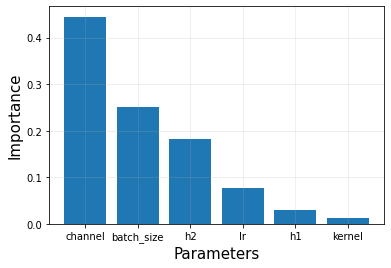

In [24]:
plt.bar(imp.keys(), height=imp.values())
plt.ylabel("Importance", fontsize=15)
plt.xlabel("Parameters", fontsize=15)
plt.grid(alpha=0.25)

In [20]:
df

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_channel,params_h1,params_h2,params_kernel,params_lr,state
0,0,0.846963,2021-04-03 10:49:31.842594,2021-04-03 10:49:48.497731,00:00:16.655137,511,37,53,24,7,0.004647,COMPLETE
1,1,0.828639,2021-04-03 10:49:48.498742,2021-04-03 10:52:36.442469,00:02:47.943727,779,54,105,50,2,0.000323,COMPLETE
2,2,0.893790,2021-04-03 10:52:36.444892,2021-04-03 10:52:59.256900,00:00:22.812008,257,52,126,98,4,0.007084,COMPLETE
3,3,0.383780,2021-04-03 10:52:59.258036,2021-04-03 10:55:47.072036,00:02:47.814000,3498,30,97,13,14,0.000012,COMPLETE
4,4,0.826603,2021-04-03 10:55:47.073006,2021-04-03 11:00:49.322959,00:05:02.249953,82,92,32,42,13,0.000019,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.522226,2021-04-03 17:21:59.570967,2021-04-03 17:23:30.402616,00:01:30.831649,3117,18,32,29,9,0.000029,COMPLETE
96,96,0.877163,2021-04-03 17:23:30.404768,2021-04-03 17:27:51.417184,00:04:21.012416,2397,119,28,24,25,0.002514,COMPLETE
97,97,0.883950,2021-04-03 17:27:51.419125,2021-04-03 17:32:44.922354,00:04:53.503229,2545,84,23,113,11,0.003725,COMPLETE
98,98,0.888022,2021-04-03 17:32:44.923442,2021-04-03 17:34:18.365867,00:01:33.442425,1137,78,53,74,21,0.008495,COMPLETE
